## Traitement des données
Importation des données

In [1]:
# Importation des bibliothèques
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_pacf
from numpy.polynomial.polynomial import polyfit
from pathlib import Path
from hypothesis import strategies as st, given, settings
from sklearn.covariance import ShrunkCovariance
from sklearn.datasets import make_gaussian_quantiles
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize, LinearConstraint
from sklearn.covariance import shrunk_covariance
import yfinance as yf
import statsmodels.api as sm

In [2]:
# Récupérer le chemin d'accès du fichier
def access_path(relative_or_absolute_path: str):
    current_path = Path(os.getcwd())
    target_path = current_path / relative_or_absolute_path

    return str(target_path.resolve())

path = access_path('..\Data') # Chemin d'accès du code vers le dossier contenant les données

# Charger les données depuis les fichiers CSV
dailycrypto = pd.read_csv(os.path.join(path,"daily_crypto_data.csv"))
Mktcapvol = pd.read_csv(os.path.join(path,"market_caps_daily.csv"))
volumebinance = pd.read_csv(os.path.join(path,"volume_binance_daily.csv"))

# Extraire les données en tant qu'arrays
Mktcapvoldata = Mktcapvol.iloc[:, 1:].values
volumebinancedata = volumebinance.iloc[:, 1:].values
dailycryptodata = dailycrypto.iloc[:, 1:].values

# Charger les données à partir de Yahoo Finance pour ^IRX entre les dates spécifiées
ticker = "^IRX"
start_date = "2021-01-01"
end_date = "2023-06-29"
#13 week bill treasury 
irx_data = yf.download(ticker, start=start_date, end=end_date)

# Sélectionner la colonne "Adj Close"
adj_close = irx_data['Adj Close']

# Supprimer les lignes contenant NaN dans la colonne "Adj Close"
adj_closeRf = adj_close.dropna()

# Calculer la moyenne du taux sans risque (rendement annualisé)
Rf = adj_closeRf.mean()/100

# Afficher la moyenne du taux sans risque
print(f"Moyenne du taux sans risque : {Rf:.4}")

[*********************100%%**********************]  1 of 1 completed

Moyenne du taux sans risque : 0.01754


Récupération des rendements en continue des daily cryptos 

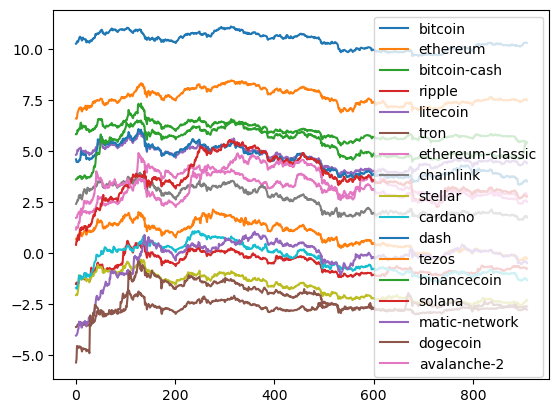

In [3]:
# Nombre de colonnes dans dailycrypto
nbcol = dailycrypto.shape[1]

# Calcul des rendements quotidiens en utilisant la différence des logarithmes
rdtdaily = np.diff(np.log(dailycryptodata), axis=0)

# Récupération du nom des colonnes
nomsColonnesString = 'bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2'
cellulesNomsColonnes = nomsColonnesString.split(',')
nomsColonnes = [col.strip() for col in cellulesNomsColonnes]
#mise en forme des rendements en DataFrame
dfrdt=pd.DataFrame(rdtdaily)
dfrdt.columns=nomsColonnes
# Représentation graphique des prix en logarithme
plt.plot(np.log(dailycryptodata))
plt.legend(nomsColonnes)
plt.show()

Représentation de la distribution des rendements 

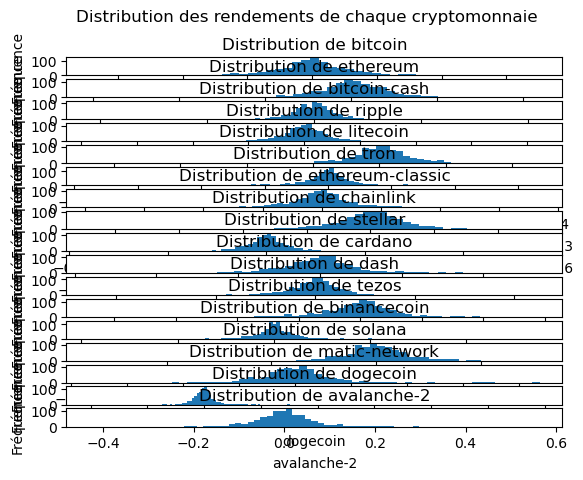

In [4]:
# Créer une nouvelle figure
plt.figure()

# Nombre total de colonnes
nbColonnes = rdtdaily.shape[1]

# Boucle pour créer les subplots
for i in range(1, nbColonnes+1):
    plt.subplot(nbColonnes, 1, i)
    
    # Afficher l'histogramme de la colonne actuelle
    plt.hist(rdtdaily[:, i-1], bins='auto')
    
    # Ajouter des étiquettes et un titre
    plt.xlabel(nomsColonnes[i-1])
    plt.ylabel('Fréquence')
    plt.title(f'Distribution de {nomsColonnes[i-1]}')

# Ajuster la disposition
plt.suptitle('Distribution des rendements de chaque cryptomonnaie')
plt.show()

Statistique sur les rendements

In [27]:
# Calcul de la kurtosis et de la skewness
kurtosisrdt_values = dfrdt.kurtosis()
skewnessrdt_values = dfrdt.skew()
SharpeRatio=(dfrdt.mean()*252-Rf/(100))/(dfrdt.std()*np.sqrt(252))
# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionrdt_with_kurtosis_skewness = dfrdt.describe().append(kurtosisrdt_values.rename('kurtosis')).append(skewnessrdt_values.rename('skewness')).append(SharpeRatio.rename('sharpe ratio annualized'))

descriptionrdt_with_kurtosis_skewness.round(5).drop('count').T

,mean,std,min,25%,50%,75%,max,kurtosis,skewness,sharpe ratio annualized
bitcoin,0.00004,0.03600,-0.17252,-0.01588,-0.00024,0.01778,0.17603,3.06372,-0.20081,0.01711
ethereum,0.00100,0.04719,-0.30520,-0.02143,0.00143,0.02701,0.21941,4.34921,-0.43463,0.33518
bitcoin-cash,-0.00046,0.05493,-0.42015,-0.02400,0.00181,0.02314,0.42311,11.69610,0.33718,-0.13393
ripple,0.00082,0.05746,-0.38653,-0.02346,0.00080,0.02412,0.42335,10.31935,0.60875,0.22640
litecoin,-0.00045,0.05149,-0.43788,-0.02353,0.00111,0.02637,0.24176,7.73465,-0.96397,-0.13817
tron,0.00111,0.04817,-0.37682,-0.01797,0.00198,0.01953,0.33411,9.97799,-0.07434,0.36621
ethereum-classic,0.00124,0.06413,-0.39374,-0.02669,0.00059,0.02483,0.36929,7.01865,0.70231,0.30649
chainlink,-0.00073,0.05867,-0.44079,-0.03069,0.00225,0.03119,0.26525,4.64660,-0.61695,-0.19666
stellar,-0.00027,0.05199,-0.36012,-0.02313,0.00124,0.02186,0.55506,18.34431,0.87782,-0.08302
cardano,0.00042,0.05364,-0.28251,-0.02736,-0.00005,0.02374,0.26920,3.47165,0.33425,0.12441


Statistiques sur les capitalisations en log

In [28]:
capi=pd.DataFrame(np.log(Mktcapvoldata))
capi.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosiscapi_values = capi.kurtosis()
skewnesscapi_values = capi.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptioncapi_with_kurtosis_skewness =capi.describe().append(kurtosiscapi_values.rename('kurtosis')).append(skewnesscapi_values.rename('skewness'))
descriptioncapi_with_kurtosis_skewness.T

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
bitcoin,910.0,27.159082,0.384120,26.433573,26.817879,27.174791,27.490281,27.876942,-1.144606,-0.099870
ethereum,910.0,26.232886,0.394095,25.145643,25.959938,26.141209,26.581219,27.071820,-0.860861,0.243062
bitcoin-cash,910.0,22.340463,0.740855,21.255250,21.565869,22.462600,23.013421,24.086262,-1.466055,0.106828
ripple,910.0,24.049923,0.432540,23.024542,23.698505,23.968652,24.395414,25.158704,-0.754836,0.318491
litecoin,910.0,22.762793,0.462177,21.839087,22.422301,22.737670,23.141236,23.968891,-0.825091,0.086862
tron,910.0,22.488240,0.294104,21.374932,22.411320,22.535486,22.646016,23.201539,3.439746,-1.483336
ethereum-classic,910.0,22.002324,0.576360,20.304529,21.698278,21.972271,22.435132,23.566117,0.165691,-0.377376
chainlink,910.0,22.533433,0.595984,21.695719,21.953359,22.572982,23.123411,23.816007,-1.502390,0.193947
stellar,910.0,22.232570,0.572017,21.345405,21.702987,22.263534,22.752516,23.544526,-1.307829,0.207210
cardano,910.0,23.912985,0.665633,22.420613,23.323313,23.804965,24.463690,25.277182,-1.234454,0.194684


Statistiques sur les volumes en log

In [29]:
volume=pd.DataFrame(np.log(volumebinancedata))
volume.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosisvolume_values = volume.kurtosis()
skewnessvolume_values = volume.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionvolume_with_kurtosis_skewness = volume.describe().append(kurtosisvolume_values.rename('kurtosis')).append(skewnessvolume_values.rename('skewness'))
descriptionvolume_with_kurtosis_skewness.T

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
bitcoin,910.0,24.118705,0.538630,22.079710,23.798102,24.126461,24.471893,25.910060,0.225994,-0.210121
ethereum,910.0,23.526234,0.669001,21.502499,23.062505,23.558121,23.980886,25.671363,0.010109,-0.059922
bitcoin-cash,910.0,20.861457,1.447044,17.497970,19.914783,20.898683,22.168635,23.667869,-0.765201,-0.285811
ripple,910.0,21.646200,0.869762,19.260619,20.978980,21.678455,22.179629,24.857922,0.129394,0.349235
litecoin,910.0,20.898365,1.086729,18.962188,20.038999,20.510741,21.703485,23.632916,-0.732111,0.605249
tron,910.0,20.534247,0.894741,18.625566,19.718940,20.577711,21.167530,23.289655,-0.517699,0.288268
ethereum-classic,910.0,20.307118,1.392086,17.392960,19.177674,20.204187,21.470594,24.729137,-0.903054,0.165568
chainlink,910.0,20.295643,0.876839,17.907810,19.689234,20.275238,20.932649,22.418220,-0.535790,-0.052475
stellar,910.0,19.361599,1.259857,16.930136,18.307509,19.315382,20.284625,23.071665,-0.768456,0.215305
cardano,910.0,20.803854,1.112167,18.305118,19.916266,20.737857,21.706039,23.581804,-0.820481,0.124040


Statistiques sur les prix 

In [30]:
Prix=pd.DataFrame(dailycryptodata)
Prix.columns=nomsColonnes
# Calcul de la kurtosis et de la skewness
kurtosisprix_values = Prix.kurtosis()
skewnessprix_values = Prix.skew()

# Utilisation de la méthode describe() suivie de l'ajout de kurtosis et skewness
descriptionprix_with_kurtosis_skewness = Prix.describe().append(kurtosisprix_values.rename('kurtosis')).append(skewnessprix_values.rename('skewness'))
descriptionprix_with_kurtosis_skewness.T

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
bitcoin,910.0,35397.991175,13480.134223,15742.444336,23096.474675,33935.295258,46298.230768,67617.015545,-0.947433,0.392794
ethereum,910.0,2254.046016,932.450139,730.147340,1570.091399,1887.702420,2940.451554,4815.004634,-0.320593,0.825279
bitcoin-cash,910.0,347.599773,253.657392,88.582560,120.364788,299.902408,528.528668,1547.082465,2.030607,1.194612
ripple,910.0,0.641181,0.312832,0.220535,0.390930,0.511841,0.827877,1.837677,0.588172,1.102205
litecoin,910.0,124.249104,62.053203,43.291987,75.997257,107.524304,167.395558,384.671618,1.070221,1.045316
tron,910.0,0.071338,0.020868,0.026840,0.060939,0.066321,0.077533,0.166178,2.633508,1.224130
ethereum-classic,910.0,31.785902,18.411803,5.672940,19.210479,25.778940,42.153092,136.381988,3.218145,1.429117
chainlink,910.0,16.183454,10.269342,5.115011,7.042267,13.767172,24.918995,51.851547,-0.328668,0.767185
stellar,910.0,0.222116,0.138981,0.071337,0.104705,0.190064,0.324024,0.727540,0.363094,0.963770
cardano,910.0,0.930444,0.647734,0.175679,0.384767,0.673389,1.311789,2.967075,0.167820,0.987973


Test de normalité des rendements

A première vue, nous pouvons voir que toutes les Kurtosis des rendements de chaque cryptomonnaies sont largement supérieur à 3, laissant penser que les rendements ne suivent pas une loi normale. Nous allors vérifier celà à l'aide du test de Jarque Bera,

In [5]:
h = np.zeros(nbColonnes)
p = np.zeros(nbColonnes)


for i in range(nbColonnes):
    jbtest_result = stats.jarque_bera(rdtdaily[:, i])
    h[i] = jbtest_result[0]
    p[i] = jbtest_result[1]
    
# Création d'un DataFrame
pd.DataFrame({
    'Jarque-Bera Statistic': h,
    'p-value': p,
},index=nomsColonnes)

,Jarque-Bera Statistic,p-value
bitcoin,356.184637,4.523648e-78
ethereum,734.947116,2.560127e-160
bitcoin-cash,5135.854374,0.000000e+00
ripple,4039.923500,0.000000e+00
litecoin,2377.523247,0.000000e+00
tron,3725.420400,0.000000e+00
ethereum-classic,1916.335355,0.000000e+00
chainlink,863.965006,2.468213e-188
stellar,12713.092088,0.000000e+00
cardano,466.629963,4.705340e-102


En faisant, le test de Jarque Bera nous rejetons la normalité des rendements pour toutes les cryptomonnaies à un seuil de 1%

In [6]:
# Aplatir toutes les données en un seul tableau numpy 1D
flat_data = rdtdaily.flatten()

# Effectuer le test de Jarque-Bera
jb_test_stat, jb_p_value = stats.jarque_bera(flat_data)

# Afficher les résultats
print("Statistique de test Jarque-Bera:", jb_test_stat)
print("P-value:", jb_p_value)

# Interpréter le résultat
if jb_p_value < 0.05:
    print("On rejette l'hypothèse de normalité au seuil de 5%")
else:
    print("On ne rejette pas l'hypothèse de normalité au seuil de 5%")


Statistique de test Jarque-Bera: 726688.6016120395
P-value: 0.0
On rejette l'hypothèse de normalité au seuil de 5%


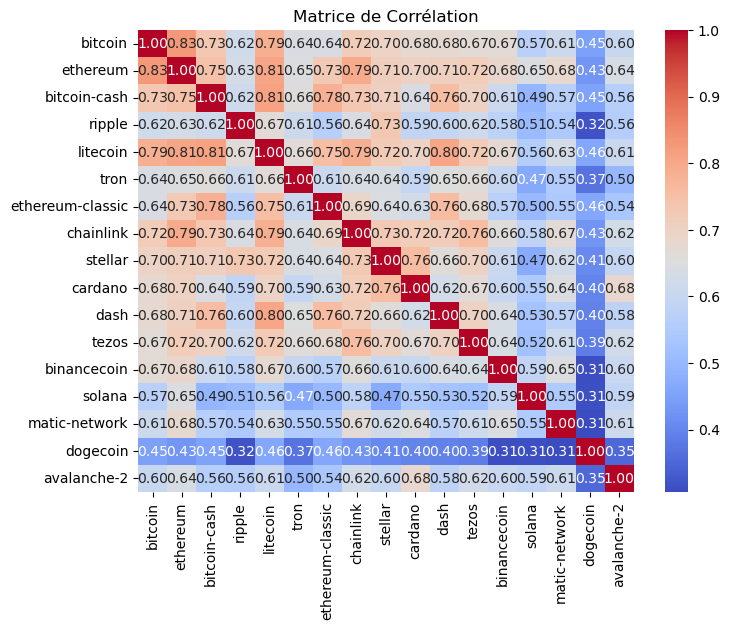

In [7]:
# Données
rdtdaily = np.diff(np.log(dailycryptodata), axis=0)
nomsColonnesString = 'bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2'
cellulesNomsColonnes = nomsColonnesString.split(',')
nomsColonnes = [col.strip() for col in cellulesNomsColonnes]

# Calcul de la matrice de corrélation
matriceCorrelation = np.corrcoef(rdtdaily, rowvar=False)

# Ajustement de la taille de la figure
plt.figure(figsize=(8, 6))

# Création du heatmap avec seaborn
sns.heatmap(matriceCorrelation, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=nomsColonnes, yticklabels=nomsColonnes)

# Ajout d'un titre
plt.title('Matrice de Corrélation')

# Affichage de la figure
plt.show()

Nous constatons qu'aucune des cryptomonnaies détiennent des corrélations négatives entre elles, il existe seulement un dégré d'indépendance entre elles. Le niveau de plus faible corrélation est entre le Solana/ le dogecoin et le binancecoin/le dogecoin avec 0.31. Le niveau le plus élevée est entre les deux plus grosses cryptomonnaies (Bitcoin/Ethereum) avec 0.83, que nous allons considérons comme nos cryptomonnaies représentant le marché.

## Les choix diversification 
Dispersion des monnaies par ecart types et moyennes de leur capitalisation, de leur rendement et de leur volume

In [8]:
meanCap = np.mean(Mktcapvoldata, axis=0)
stdCap = np.std(Mktcapvoldata, axis=0)

meanrdt = np.mean(rdtdaily, axis=0)
stdrdt = np.std(rdtdaily, axis=0)

meanVolume = np.mean(volumebinancedata, axis=0)
stdVolume = np.std(volumebinancedata, axis=0)

Diversfication par la capitalisation

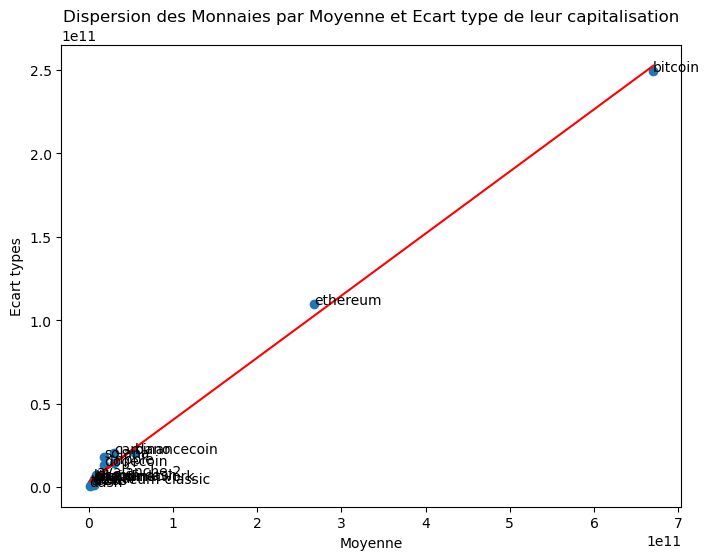

In [9]:
# Tracer un graphe de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(meanCap, stdCap)

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap, stdCap, 1)
plt.plot(meanCap, b + m * meanCap, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation')

plt.show()

A l'échelle logaritmique

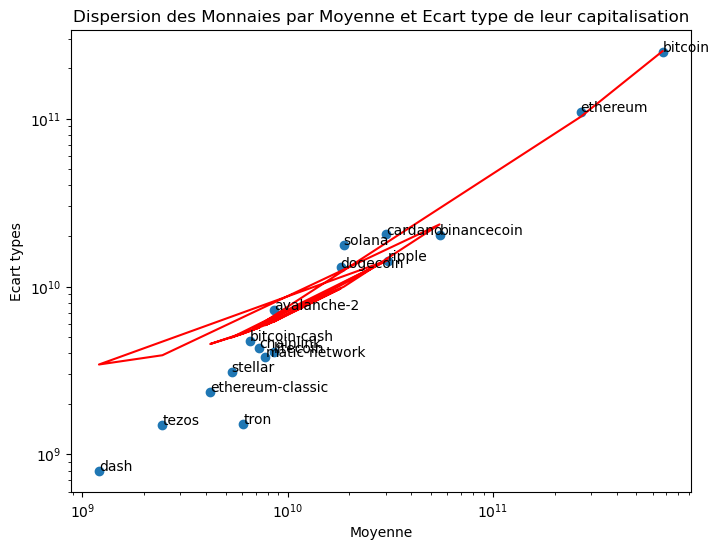

In [10]:

# Tracer un graphe de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(meanCap, stdCap)

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap, stdCap, 1)
plt.plot(meanCap, b + m * meanCap, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation')

# Mettre à l'échelle logarithmique
plt.xscale('log')
plt.yscale('log')

plt.show()


Nous retraçons la droite de régression en supprimant Bitcoin et Ethereum puisque leur capitalisation est largement plus élevée que les autres cryptomonnaies. Ainsi, nous allons les mettre dans une catégorie LargeCap Crypto.

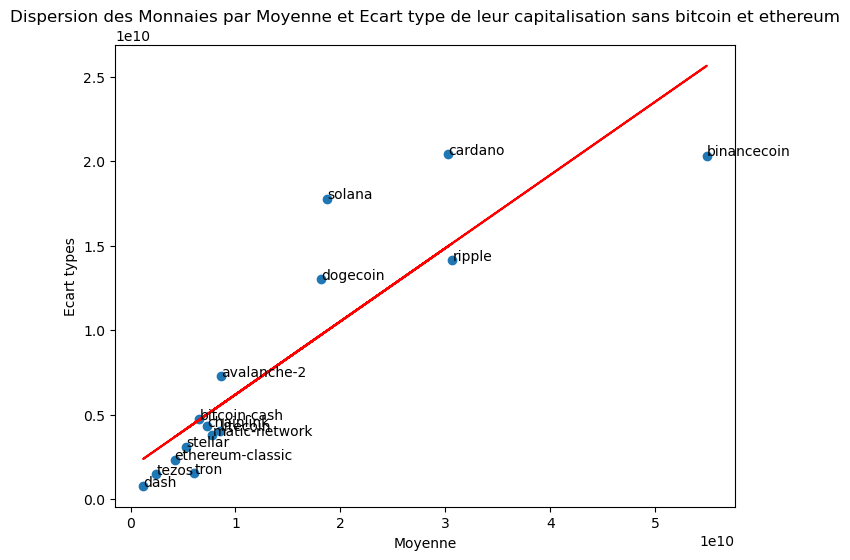

In [11]:

# Tracer un graphe de dispersion sans bitcoin et ethereum
plt.figure(figsize=(8, 6))
plt.scatter(meanCap[2:], stdCap[2:])

# Tracer la droite de régression linéaire
b, m = polyfit(meanCap[2:], stdCap[2:], 1)
plt.plot(meanCap[2:], b + m * meanCap[2:], color='red')

# Ajouter des étiquettes aux points
for i in range(2, len(nomsColonnes)):
    plt.text(meanCap[i], stdCap[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur capitalisation sans bitcoin et ethereum')

plt.show()


Au vue de ce graphique nous pouvons mieux discerner les autres capitalisations avec en MidCap (Cardano, BinanceCoin, ripple, solana, Dogecoin, Avanlache-2) et en SmallCap (Bitcoin-cash, chainlink, litecoin, matic-network, stellar,ethereum-classic, tron, tezos, dash)

### Diversification par le volume

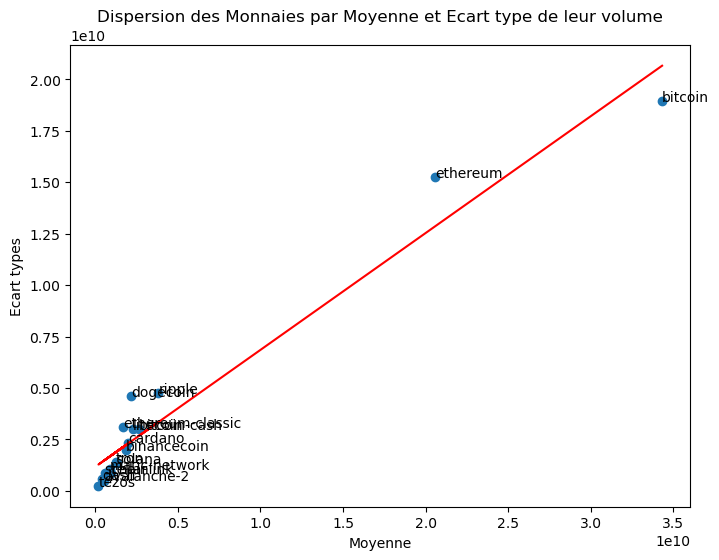

In [12]:

# Tracer un graphe de dispersion du volume
plt.figure(figsize=(8, 6))
plt.scatter(meanVolume, stdVolume)

# Tracer la droite de régression linéaire
b, m = polyfit(meanVolume, stdVolume, 1)
plt.plot(meanVolume, b + m * meanVolume, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanVolume[i], stdVolume[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur volume')

plt.show()


Des résultats similaires à celui de la régression sur le volume, les plus gros volumes d'échanges sont les plus grosses capitalisations .

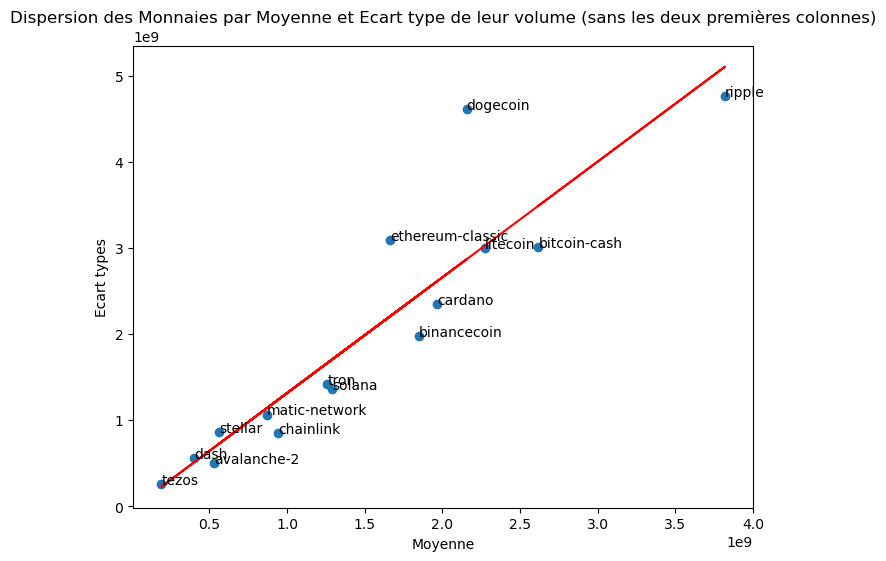

In [13]:

# Tracer un graphe de dispersion du volume sans les deux premières colonnes
plt.figure(figsize=(8, 6))
plt.scatter(meanVolume[2:], stdVolume[2:])

# Tracer la droite de régression linéaire
b, m = polyfit(meanVolume[2:], stdVolume[2:], 1)
plt.plot(meanVolume[2:], b + m * meanVolume[2:], color='red')

# Ajouter des étiquettes aux points
for i in range(2, len(nomsColonnes)):
    plt.text(meanVolume[i], stdVolume[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leur volume (sans les deux premières colonnes)')

plt.show()


Néanmoins nous avons quelques différences entre les volumes Mid et les Mid cap; les "small" Volumes et les "small" capitalisations. 
MidVolume=dogecoin,ripple, ethereum-classic,litecoin, bitcoin-cash, cardano, binancecoin

SmallVolume=Tron, solana, matic-network, stellar, chainlink, dash, avalanche-2,tezos

Le smallVolume est un facteur essentiel à prendre au sein de la construction de notre portefeuille puisqu'il indique une faible liquidité du produit donc la difficulté de rebalancer le portefeuille si nécessaire.


### Diversification par les rendements
Nous allons regarder la dispersion des cryptos en fonction de leur moyenne et de leur écart type, ces résultats pourront être vu comme un proxy du ratio de Sharpe (en supposant un taux sans risque à 0).

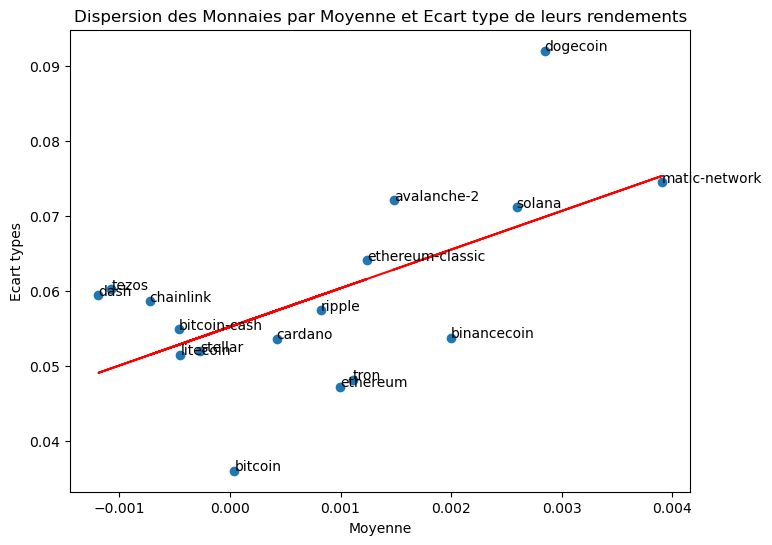

In [14]:
# Tracer un graphe de dispersion des rendements
plt.figure(figsize=(8, 6))
plt.scatter(meanrdt, stdrdt)

# Tracer la droite de régression linéaire
b, m = polyfit(meanrdt, stdrdt, 1)
plt.plot(meanrdt, b + m * meanrdt, color='red')

# Ajouter des étiquettes aux points
for i in range(len(nomsColonnes)):
    plt.text(meanrdt[i], stdrdt[i], nomsColonnes[i])

# Ajouter des étiquettes et un titre
plt.xlabel('Moyenne')
plt.ylabel('Ecart types')
plt.title('Dispersion des Monnaies par Moyenne et Ecart type de leurs rendements')

plt.show()


Nous constatons qu'une partie des rendements rapportent des rendements négatifs avec un minimum de volatilité.

# Construction des portefeuilles

Dans cette partie, nous allons construire les différents portefeuilles : MDP, MinVar, portefeuille à contribution égale au risque et le portefeuille équipondéré. Une fois la construction de ces différents portefeuilles avec les différents rendements jounaliers de chaque cryptomonnaies, nous allons modéliser leurs évolutions à l'aide de différents modèles à un ou plusieurs facteurs.

## Most Doversified Portfolio


Dans un premier temps, nous allons considérer le MDP, le portefeuille qui minimise le diversification ratio, 
\begin{align*}
& \quad DR(w) = \left[CR(w)(1 - \rho(w)) + \rho(w)\right]^{-\frac{1}{2}} \\
\end{align*}
avec 
\begin{align*}
&\text{Volatility Weighted Average Correlation} = \frac{\sum_{i \neq j} w_i \cdot w_j \cdot \rho(i, j) \cdot \sigma_i \cdot \sigma_j}{\sum_{i \neq j} w_i \cdot \sigma_i \cdot w_j \cdot \sigma_j}
\end{align*}

\begin{align*}
\text{Min :} & \quad DR(w) \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
& \quad \Sigma w^{MDP} \geq \frac{\sigma(w^{MDP}) \sigma_i}{DR(w^{MDP})} \\
& \text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [10]:
def VWAC(weights, correlations, volatilities):
    N = len(weights)
    
    numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j] 
                      for i in range(N) for j in range(N) if i != j)
    
    denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j] 
                        for i in range(N) for j in range(N) if i != j)
    
    return numerator / denominator

def CR(w, covariance_matrix):
    N = len(w)
    CRatio = 0
    CRatio2=0
    volatility_vector = np.diag(covariance_matrix)
    total_volatility = np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))

    for i in range(N):
        CRatio += (w[i] * volatility_vector[i]) ** 2
        CRatio2+=w[i] * volatility_vector[i]
    return  CRatio / (CRatio2 ** 2)

Covariance = np.cov(rdtdaily, rowvar=False) #rebalancement annuel
Corrmatrix=np.corrcoef(rdtdaily, rowvar=False)

C_shrunk= Covariance

def DR(w, covariance_matrix = C_shrunk, corrmatrix = Corrmatrix):
    dr=((CR(w, covariance_matrix) * (1 - VWAC(w,corrmatrix,covariance_matrix)) + VWAC(w,corrmatrix,covariance_matrix))**-0.5)
    #dr=np.dot(w.T, C_shrunk)/np.sqrt(np.dot(w.T, np.dot(C_shrunk, w)))
    return np.dot(w.T,dr)

def DRobj(w) :
    return -np.log(DR(w))

# Contraintes d'égalité
Aeq = np.ones((1, rdtdaily.shape[1]))
beq = 1

# Bornes des variables de décision
lb =np.zeros(rdtdaily.shape[1])
ub = np.ones(rdtdaily.shape[1])

# Initialisation des variables
x0 = np.ones(rdtdaily.shape[1]) / rdtdaily.shape[1]

def ineq_constraint(w):
    return np.dot(Covariance, w) - (np.sqrt(np.var(w)) / DR(w)) * np.diag(Covariance)

# Résolution du problème d'optimisation
resultMDP = minimize(DRobj, x0, constraints=[{'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq},{'type': 'ineq', 'fun': ineq_constraint}],
                  bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': True})

xMDP = resultMDP.x
DRMDP = DR(xMDP)

# Affichage des résultats
print("Résultats de l'optimisation :")
print("Variables optimales :", xMDP)
portfolioVarMDP = xMDP @ C_shrunk @ xMDP
print("Variance du portefeuille MDP :", np.dot(xMDP.T, np.dot(C_shrunk, xMDP)))
print("Diversification ratio :", DRMDP)


# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfMDP = np.dot(xMDP, rdtdaily.T)
MktcapvolMDP = np.dot(xMDP, Mktcapvoldata.T)
volumeMDP = np.dot(xMDP, volumebinancedata.T)



C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2833701989830898
            Iterations: 10
            Function evaluations: 181
            Gradient evaluations: 10
Résultats de l'optimisation :
Variables optimales : [1.39367555e-18 2.08116930e-17 1.89593557e-17 1.57197037e-01
 3.13413720e-17 2.09657109e-01 6.70330201e-02 2.30335289e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.08275179e-03 1.72909273e-01 1.11740420e-01 1.80852049e-01
 9.85283392e-02]
Variance du portefeuille MDP : 0.0025089027901167398
Diversification ratio : 1.327596545747819


In [42]:
print(f"Contrainte d'inégalité : {np.all(np.dot(Covariance, xMDP) - (np.sqrt(np.var(xMDP)) / DR(xMDP)) * np.diag(Covariance)>0)}")

Contrainte d'inégalité : True


C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [18]:
def test_convergence(xMDP, cov = Covariance):
    error_count = 0
    total_count = 0
    failing_cases = []
    successful_cases = [] 
    successful_MDP = []
    failing_DR = []

    dr_opt = round(DR(xMDP), 5)
    interval = [dr_opt + i / 10000 for i in range(-1, 2, 1)]

    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))
    
    def ineq_constraint(w):
        return np.dot(cov, w) - (np.sqrt(np.var(w)) / DR(w)) * np.diag(cov)
    
    @settings(deadline=3000, max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xMDP), max_size=len(xMDP)))
    def check_convergence(w):
        nonlocal error_count, total_count, failing_cases, successful_cases, successful_MDP, failing_DR, interval
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        if sum_w == 0:
            total_count -= 1
        else:
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            result = minimize(DRobj, w, constraints=[{'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq},{'type': 'ineq', 'fun': ineq_constraint}],
                              bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': False})

            x = result.x
            dr = round(DR(x), 5)
            
            if not np.isnan(dr):
                try:
                    assert dr in interval
                    successful_cases.append(w)
                    successful_MDP.append(x)  # Ajouter w à la liste des cas réussis
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_DR.append(dr)
                    print(f"DR(w) : {dr}")

    check_convergence()

    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1 - error_count / total_count) * 100, 2)}%")

    return successful_cases, successful_MDP
    
# Utilisation de la fonction avec un vecteur xMDP donné
print(f"DR optimal : {round(DRMDP,5)}")
successful_cases, successful_MDP =test_convergence(xMDP)

DR optimal : 1.3276


C:\Users\aikan\AppData\Local\Temp\ipykernel_18236\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_18236\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_18236\1408535971.py:10: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


DR(w) : 1.32759
Nombre total de cas testés : 999
Nombre de cas ayant échoué : 1
Taux de réussite : 99.9%


In [ ]:
pd.DataFrame(successful_cases)

In [20]:
pd.DataFrame(successful_MDP)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.526816e-17,3.408291e-17,0.0,0.156947,8.644224e-17,0.208766,0.067500,3.305879e-17,0.000000e+00,0.000000e+00,0.000000e+00,7.035285e-18,0.004290,0.172481,0.111022,0.180534,0.098459
1,1.117570e-19,0.000000e+00,0.0,0.156595,2.564408e-17,0.211200,0.066416,1.604988e-17,1.717976e-17,0.000000e+00,0.000000e+00,1.403127e-17,0.002282,0.172789,0.111289,0.180657,0.098772
2,1.485053e-17,2.401935e-18,0.0,0.156489,4.283049e-17,0.208781,0.067591,2.677271e-17,0.000000e+00,5.043487e-18,1.101072e-17,0.000000e+00,0.004329,0.172551,0.111022,0.180715,0.098522
3,1.166217e-17,0.000000e+00,0.0,0.157288,5.781353e-17,0.208684,0.067782,2.052056e-17,0.000000e+00,1.145578e-17,0.000000e+00,3.341255e-18,0.003837,0.172493,0.110952,0.180573,0.098392
4,6.245244e-18,0.000000e+00,0.0,0.156858,0.000000e+00,0.208716,0.067845,0.000000e+00,0.000000e+00,0.000000e+00,1.750532e-18,2.299245e-17,0.003673,0.172599,0.111129,0.180581,0.098598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,0.000000e+00,0.000000e+00,0.0,0.157637,6.179008e-17,0.208512,0.067798,0.000000e+00,0.000000e+00,0.000000e+00,1.042228e-18,7.065521e-17,0.003901,0.172586,0.111160,0.180528,0.097878
972,0.000000e+00,0.000000e+00,0.0,0.157637,6.179008e-17,0.208512,0.067798,0.000000e+00,0.000000e+00,0.000000e+00,1.042228e-18,7.065521e-17,0.003901,0.172586,0.111160,0.180528,0.097878
973,0.000000e+00,9.648102e-17,0.0,0.157246,4.888144e-17,0.208867,0.067005,0.000000e+00,2.301147e-18,1.811359e-17,3.691736e-17,0.000000e+00,0.004497,0.172311,0.110696,0.180555,0.098822
974,2.344267e-17,1.175443e-17,0.0,0.157246,9.276520e-18,0.208867,0.067005,5.120654e-17,3.669808e-18,0.000000e+00,1.554495e-17,3.684134e-18,0.004497,0.172311,0.110696,0.180555,0.098822


In [44]:
def correlation(w, w_s, covariance_matrix):
    return np.dot(w.T,np.dot(covariance_matrix,w_s))/np.sqrt(np.var(w_s)*np.var(w))

def test_correlation(xopt):
    error_count = 0
    total_count = 0
    failing_cases = []
    failing_DR = []
    failing_rho = []
    failing_ratio = []

    dr_opt = DR(xopt)
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))

    @settings(max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xopt), max_size=len(xopt)))
    def check_correlation(w):
        nonlocal error_count, total_count, failing_cases, failing_DR, failing_rho, failing_ratio
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1
        else :
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            cov_mat = np.cov(rdtdaily, rowvar=False) 
            rho = round(correlation(w, xopt, cov_mat), 4)
            ratio = round(DR(w) / dr_opt, 4)
            if np.isnan(ratio) :
                total_count-=1
            else :
                try:
                    assert rho >= ratio
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_rho.append(rho)
                    failing_DR.append(DR(w))
                    failing_ratio.append(ratio)
                    print(f"rho : {rho}, ratio : {ratio}, DR is max: {ratio<=1}")

    check_correlation()
        
    return [total_count, error_count]

# Utilisation de la fonction avec un vecteur xMDP donné
[total_count, error_count] = test_correlation(xMDP)
print(f"Nombre total de cas testés : {total_count}")
print(f"Nombre de cas ayant échoué : {error_count}")
print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")

C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:10: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator


rho : 0.1455, ratio : 0.824, DR is max: True
rho : 0.3002, ratio : 0.8835, DR is max: True
rho : 0.3133, ratio : 0.8832, DR is max: True
rho : 0.3207, ratio : 0.896, DR is max: True
rho : 0.2364, ratio : 0.8467, DR is max: True
rho : 0.1923, ratio : 0.8181, DR is max: True
rho : 0.1923, ratio : 0.8181, DR is max: True
rho : 0.2364, ratio : 0.8467, DR is max: True
rho : 0.1133, ratio : 0.7554, DR is max: True
rho : 0.1586, ratio : 0.7639, DR is max: True
rho : 0.3432, ratio : 0.9071, DR is max: True
rho : 0.22, ratio : 0.8613, DR is max: True
rho : 0.1239, ratio : 0.8398, DR is max: True
rho : 0.2579, ratio : 0.914, DR is max: True
rho : 0.2579, ratio : 0.914, DR is max: True
rho : 0.2834, ratio : 0.9121, DR is max: True
rho : 0.1826, ratio : 0.859, DR is max: True
rho : 0.3237, ratio : 0.9506, DR is max: True
rho : 0.3237, ratio : 0.9506, DR is max: True
rho : 0.3043, ratio : 0.945, DR is max: True
rho : 0.1995, ratio : 0.8417, DR is max: True
rho : 0.1552, ratio : 0.7532, DR is max: T

rho : 0.2521, ratio : 0.8381, DR is max: True
rho : 0.2289, ratio : 0.8282, DR is max: True
rho : 0.2289, ratio : 0.8282, DR is max: True
rho : 0.2289, ratio : 0.8282, DR is max: True
rho : 0.2633, ratio : 0.8636, DR is max: True
rho : 0.2633, ratio : 0.8636, DR is max: True
rho : 0.2633, ratio : 0.8636, DR is max: True
rho : 0.2365, ratio : 0.8483, DR is max: True
rho : 0.2017, ratio : 0.8349, DR is max: True
rho : 0.2017, ratio : 0.8349, DR is max: True
rho : 0.237, ratio : 0.8526, DR is max: True
rho : 0.3472, ratio : 0.9134, DR is max: True
rho : 0.3057, ratio : 0.9596, DR is max: True
rho : 0.2155, ratio : 0.8594, DR is max: True
rho : 0.2477, ratio : 0.8745, DR is max: True
rho : 0.2776, ratio : 0.8838, DR is max: True
rho : 0.2493, ratio : 0.8689, DR is max: True
rho : 0.2493, ratio : 0.8689, DR is max: True
rho : 0.2086, ratio : 0.8562, DR is max: True
rho : 0.284, ratio : 0.897, DR is max: True
rho : 0.1466, ratio : 0.8191, DR is max: True
rho : 0.1466, ratio : 0.8191, DR is m

rho : 0.2511, ratio : 0.8612, DR is max: True
rho : 0.191, ratio : 0.8405, DR is max: True
rho : 0.1741, ratio : 0.8244, DR is max: True
rho : 0.1741, ratio : 0.8244, DR is max: True
rho : 0.126, ratio : 0.7532, DR is max: True
rho : 0.2437, ratio : 0.8638, DR is max: True
rho : 0.126, ratio : 0.7532, DR is max: True
rho : 0.411, ratio : 0.9495, DR is max: True
rho : 0.3829, ratio : 0.9514, DR is max: True
rho : 0.4273, ratio : 0.947, DR is max: True
rho : 0.4273, ratio : 0.947, DR is max: True
rho : 0.3835, ratio : 0.9586, DR is max: True
rho : 0.3834, ratio : 0.9586, DR is max: True
rho : 0.3834, ratio : 0.9586, DR is max: True
rho : 0.3756, ratio : 0.9385, DR is max: True
rho : 0.3158, ratio : 0.8893, DR is max: True
rho : 0.2464, ratio : 0.8564, DR is max: True
rho : 0.2464, ratio : 0.8564, DR is max: True
rho : 0.3295, ratio : 0.8896, DR is max: True
rho : 0.3295, ratio : 0.8896, DR is max: True
rho : 0.2914, ratio : 0.8966, DR is max: True
rho : 0.33, ratio : 0.9542, DR is max: T

rho : 0.2541, ratio : 0.8646, DR is max: True
rho : 0.2637, ratio : 0.854, DR is max: True
rho : 0.4331, ratio : 0.9031, DR is max: True
rho : 0.2162, ratio : 0.8349, DR is max: True
rho : 0.2162, ratio : 0.8349, DR is max: True
rho : 0.2517, ratio : 0.8755, DR is max: True
rho : 0.2162, ratio : 0.8349, DR is max: True
rho : 0.2161, ratio : 0.8847, DR is max: True
rho : 0.1753, ratio : 0.7532, DR is max: True
rho : 0.2381, ratio : 0.8707, DR is max: True
rho : 0.2221, ratio : 0.8917, DR is max: True
rho : 0.1882, ratio : 0.85, DR is max: True
rho : 0.2337, ratio : 0.8608, DR is max: True
rho : 0.1161, ratio : 0.7532, DR is max: True
rho : 0.3458, ratio : 0.9484, DR is max: True
rho : 0.2927, ratio : 0.8769, DR is max: True
rho : 0.2996, ratio : 0.8817, DR is max: True
rho : 0.2397, ratio : 0.8879, DR is max: True
rho : 0.3202, ratio : 0.8939, DR is max: True
rho : 0.3202, ratio : 0.8939, DR is max: True
rho : 0.1463, ratio : 0.796, DR is max: True
rho : 0.0776, ratio : 0.7532, DR is ma

rho : 0.1273, ratio : 0.7637, DR is max: True
rho : 0.1939, ratio : 0.8614, DR is max: True
rho : 0.194, ratio : 0.8614, DR is max: True
rho : 0.172, ratio : 0.8483, DR is max: True
rho : 0.2169, ratio : 0.8372, DR is max: True
rho : 0.2169, ratio : 0.8372, DR is max: True
rho : 0.2511, ratio : 0.8497, DR is max: True
rho : 0.2169, ratio : 0.8372, DR is max: True
rho : 0.3106, ratio : 0.8725, DR is max: True
rho : 0.2881, ratio : 0.8676, DR is max: True
rho : 0.3258, ratio : 0.8737, DR is max: True
rho : 0.2552, ratio : 0.8794, DR is max: True
rho : 0.2552, ratio : 0.8794, DR is max: True
rho : 0.2552, ratio : 0.8794, DR is max: True
rho : 0.2901, ratio : 0.8986, DR is max: True
rho : 0.1349, ratio : 0.7532, DR is max: True
rho : 0.1349, ratio : 0.7532, DR is max: True
rho : 0.2078, ratio : 0.8675, DR is max: True
rho : 0.2169, ratio : 0.848, DR is max: True
rho : 0.2408, ratio : 0.8602, DR is max: True
rho : 0.2876, ratio : 0.8713, DR is max: True
rho : 0.3406, ratio : 0.901, DR is ma

rho : 0.2372, ratio : 0.8521, DR is max: True
rho : 0.3021, ratio : 0.9549, DR is max: True
rho : 0.3646, ratio : 0.9135, DR is max: True
rho : 0.4024, ratio : 0.9052, DR is max: True
rho : 0.2289, ratio : 0.8282, DR is max: True
rho : 0.1927, ratio : 0.819, DR is max: True
rho : 0.1927, ratio : 0.819, DR is max: True
rho : 0.1349, ratio : 0.7533, DR is max: True
rho : 0.1349, ratio : 0.7533, DR is max: True
rho : 0.2524, ratio : 0.8883, DR is max: True
rho : 0.2673, ratio : 0.8979, DR is max: True
rho : 0.2673, ratio : 0.8979, DR is max: True
rho : 0.2999, ratio : 0.904, DR is max: True
rho : 0.2006, ratio : 0.8481, DR is max: True
rho : 0.1599, ratio : 0.8314, DR is max: True
rho : 0.1599, ratio : 0.8314, DR is max: True
rho : 0.1959, ratio : 0.8716, DR is max: True
rho : 0.1844, ratio : 0.8581, DR is max: True
rho : 0.1496, ratio : 0.7533, DR is max: True
rho : 0.1758, ratio : 0.8537, DR is max: True
rho : 0.1758, ratio : 0.8537, DR is max: True
rho : 0.1758, ratio : 0.8537, DR is m

In [ ]:
def test_MDP(Xopt, xinit = xMDP):
    rate_min = 1
    MDPopt = []
    for xopt in Xopt :
        res = test_correlation(xopt)
        rate = res[1]/res[0]
        if rate < rate_min :
            MDPopt = xopt 
            rate_min = rate
    if rate_min == 1 :
        MDPopt = xinit
    return [MDPopt, rate_min]

[MDPopt,r] = test_MDP(successful_MDP)
print(f"MDP optimal : {MDPopt}")
print(f"Taux de réussite : {round((1-r)*100,2)}")


In [46]:
def test_DR(xMDP):
    error_count = 0
    total_count = 0
    failing_cases = []
    failing_DR = []
    failing_rho = []
    failing_ratio = []

    dr_opt = DR(xMDP)
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))

    @settings(max_examples=1000)
    @given(st.lists(custom_value_strategy, min_size=len(xMDP), max_size=len(xMDP)))
    def check_DR(w):
        nonlocal error_count, total_count, failing_cases, failing_DR, failing_rho, failing_ratio
        total_count += 1

        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1
        else :
            w /= sum_w  # Normaliser w pour que la somme des coefficients soit 1
            cov_mat = np.cov(rdtdaily, rowvar=False)
            rho = round(correlation(w, xMDP, cov_mat), 4)
            ratio = round(DR(w) / dr_opt, 4)
            if np.isnan(ratio) :
                total_count-=1
            else :
                try:
                    assert ratio<=1
                except AssertionError:
                    error_count += 1
                    failing_cases.append(w)
                    failing_rho.append(rho)
                    failing_DR.append(DR(w))
                    failing_ratio.append(ratio)
                    print(f"rho : {rho} ratio : {ratio}, DR(w) : {DR(w)}")

    check_DR()
    
    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")
    
# Utilisation de la fonction avec un vecteur xMDP donné
test_DR(xMDP)

C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:10: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator


Nombre total de cas testés : 977
Nombre de cas ayant échoué : 0
Taux de réussite : 100.0%


In [47]:
print(f"Déterminant de la matrice de covariance : {round(np.linalg.det(Covariance),54)}")
pd.DataFrame(np.linalg.inv(Covariance))

Déterminant de la matrice de covariance : 1.58713e-49


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3139.284021,-1109.259809,-294.888511,-36.511418,-448.432664,-128.160569,254.177622,78.184446,-139.577118,-123.749983,-9.542025,21.280791,-208.511200,-21.101267,33.029898,-84.066125,-21.983015
1,-1109.259809,2424.292986,-19.944682,70.076382,-327.017798,-36.143023,-302.035766,-348.968495,-92.345722,12.790375,137.786057,-42.221773,-41.915882,-209.979124,-128.853595,27.860973,-26.574810
2,-294.888511,-19.944682,1393.177573,7.022094,-378.933896,-114.222505,-350.809811,-94.584919,-175.897079,85.879341,-117.067483,-48.001213,14.444308,43.418730,32.603626,-16.058670,-19.519029
3,-36.511418,70.076382,7.022094,782.883223,-167.651935,-145.126579,-8.170545,-41.073779,-420.338630,116.339069,29.578026,-14.395979,-33.008467,-75.733821,7.795897,26.107783,-68.372969
4,-448.432664,-327.017798,-378.933896,-167.651935,2053.833017,26.495346,-69.949422,-201.269113,56.283099,-129.081949,-439.278329,-16.747455,-75.815125,43.920660,-12.594165,-44.734769,43.011174
5,-128.160569,-36.143023,-114.222505,-145.126579,26.495346,1023.667495,-0.679923,16.214271,-26.495163,-68.760267,-127.138358,-152.664026,-98.873462,7.404884,-31.766062,-19.419528,61.448426
6,254.177622,-302.035766,-350.809811,-8.170545,-69.949422,-0.679923,862.880715,28.416994,14.849755,-83.658216,-271.181746,-76.242616,28.467046,-10.190165,7.107892,-56.740579,27.452372
7,78.184446,-348.968495,-94.584919,-41.073779,-201.269113,16.214271,28.416994,1182.579848,-96.337720,-134.158342,-82.816591,-225.866775,-26.471424,-39.841665,-78.366753,-21.438189,8.433813
8,-139.577118,-92.345722,-175.897079,-420.338630,56.283099,-26.495163,14.849755,-96.337720,1462.224965,-475.719651,-33.668225,-113.259261,-5.315242,131.426584,-58.919432,-27.404136,33.739223
9,-123.749983,12.790375,85.879341,116.339069,-129.081949,-68.760267,-83.658216,-134.158342,-475.719651,1157.810907,58.093007,-15.729889,28.668492,-55.779122,-75.630425,-3.398352,-203.743901


In [11]:
def make_polico(w, rdtmat = rdtdaily):
    rdtpolico = np.hstack((rdtmat, np.dot(rdtmat, w).reshape(-1, 1)))
    return rdtpolico

rdtpolico = make_polico(np.array([1/17 for i in range(17)]))
pd.DataFrame(rdtpolico)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.011296,-0.011533,-0.006644,0.073847,0.009432,0.003928,0.004494,0.052111,0.028596,-0.035741,-0.120714,-0.004082,0.013612,0.194437,0.013770,0.162716,0.133791,0.030783
1,0.091477,0.063089,0.038987,-0.067810,0.088967,0.013067,0.016064,0.029933,-0.029886,0.014166,-0.013090,-0.003198,0.011376,-0.021139,0.065615,0.649462,-0.045972,0.053006
2,0.025914,0.217863,0.167479,0.016835,0.146914,0.086569,0.135466,0.111024,0.056904,0.140370,0.020902,0.062217,0.068857,0.175155,0.046689,-0.049928,-0.011695,0.083384
3,-0.046275,0.058887,-0.053992,0.039035,-0.047685,0.026238,0.033253,-0.025002,0.182727,0.065371,-0.020689,0.061926,-0.027419,0.120103,0.172839,-0.050312,0.015829,0.029696
4,0.078294,0.073027,0.054431,-0.034337,0.044974,-0.064711,0.048657,0.090638,0.180872,0.169085,0.022543,0.048782,0.042550,-0.113532,0.032772,0.025671,0.199506,0.052896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,-0.002989,-0.008648,0.164949,-0.019203,-0.017355,-0.012829,0.020388,0.014733,0.013284,-0.021376,0.013726,0.034928,-0.032420,-0.027887,-0.028244,-0.023020,-0.019011,0.002884
905,-0.002724,0.012764,-0.081282,0.005891,-0.014917,0.013515,-0.043394,0.000710,0.012207,0.008269,0.008348,-0.003077,0.009398,0.019619,0.018734,-0.000325,0.031256,-0.000295
906,-0.005573,-0.020935,0.130671,-0.021518,-0.011016,0.008552,0.014910,-0.012865,0.004811,-0.039829,0.022742,-0.028919,-0.010820,-0.040681,-0.033717,-0.029186,-0.021458,-0.005578
907,0.013383,0.016113,0.023155,0.010835,0.008314,0.007291,0.002795,0.021757,0.102412,0.020277,-0.004492,0.010815,0.005599,0.019465,0.029166,0.011912,0.004446,0.017838


In [36]:
def optimize_DR(rdtmat, disp = False):
    
    Covmat = np.cov(rdtmat, rowvar=False) #rebalancement annuel
    Corrmat=np.corrcoef(rdtmat, rowvar=False)
    
    def DRobj_loc(w) :
        return -np.log(DR(w, covariance_matrix = Covmat, corrmatrix = Corrmat))

    def ineq_constraint(w):
        return np.dot(Covmat, w) - (np.sqrt(np.var(w)) / DR(w, covariance_matrix = Covmat, corrmatrix = Corrmat)) * np.diag(Covmat)
    
    # Contraintes d'égalité
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    # Bornes des variables de décision
    lb =np.zeros(rdtmat.shape[1])
    ub = np.ones(rdtmat.shape[1])

    # Initialisation des variables
    w0 = np.ones(rdtmat.shape[1]) / rdtmat.shape[1]

    # Résolution du problème d'optimisation
    result = minimize(DRobj_loc, w0, 
                      constraints=[{'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq},
                                   {'type': 'ineq', 'fun': ineq_constraint}],
                      bounds=[(l, u) for l, u in zip(lb, ub)], options={'disp': disp})
    return result

result = optimize_DR(rdtpolico, True)
xMDPpolico = result.x
C_shrunk = np.cov(rdtpolico, rowvar=False)
drMDPpolico = DR(xMDPpolico,covariance_matrix = C_shrunk, corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
# Affichage des résultats
print("Résultats de l'optimisation :")
print("Variables optimales avec polico :", xMDPpolico)
print("Variables optimales :", xMDP)
portfolioVarMDP = xMDPpolico @ C_shrunk @ xMDPpolico
print("Variance du portefeuille MDP :", np.dot(xMDPpolico.T, np.dot(C_shrunk, xMDPpolico)))
print("Diversification ratio :", drMDPpolico)


C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2833695544568273
            Iterations: 10
            Function evaluations: 190
            Gradient evaluations: 10
Résultats de l'optimisation :
Variables optimales avec polico : [4.40423973e-17 5.16751810e-17 2.01231418e-17 1.57738463e-01
 2.63532620e-18 2.10158336e-01 6.66221504e-02 3.54967754e-17
 0.00000000e+00 2.04834284e-17 0.00000000e+00 1.12565782e-17
 1.21298716e-03 1.73110728e-01 1.12209116e-01 1.80736339e-01
 9.82118800e-02 4.50908758e-17]
Variables optimales : [1.39367555e-18 2.08116930e-17 1.89593557e-17 1.57197037e-01
 3.13413720e-17 2.09657109e-01 6.70330201e-02 2.30335289e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.08275179e-03 1.72909273e-01 1.11740420e-01 1.80852049e-01
 9.85283392e-02]
Variance du portefeuille MDP : 0.0025090071334213297
Diversification ratio : 1.327595690077255


In [50]:
def test_polico(rdtmat, dr_opt):
    error_count = 0
    total_count = 0
    failing_polico = []
    failing_ratio = []
    n = rdtmat.shape[1] 

    interval = [dr_opt + i / 10000 for i in range(-1, 2, 1)]
    
    custom_value_strategy = st.one_of(
        st.just(0),
        st.floats(min_value=1e-18, max_value=1.0))
    @settings(deadline=7000, max_examples=100)
    @given(st.lists(custom_value_strategy, min_size=n, max_size=n))
    def check_polico(w):
        nonlocal error_count, total_count, failing_polico, failing_ratio
        total_count += 1
        w = np.array(w)
        sum_w = np.sum(w)
        # Vérification supplémentaire pour éviter la division par zéro
        if sum_w == 0 :
            total_count-=1 
        else :
            w = w/sum_w
            rdtpolico = make_polico(w, rdtmat)
            optimized_result = optimize_DR(rdtpolico, False)
            dr = DR(optimized_result.x, covariance_matrix=np.cov(rdtpolico, rowvar=False), corrmatrix=np.corrcoef(rdtpolico, rowvar=False))
            dr = round(dr, 4) 
            if np.isnan(dr):
                total_count-=1 
            else :
                try:
                    assert dr in interval
                except AssertionError:
                    error_count+=1
                    failing_polico.append(optimized_result.x)
                    failing_ratio.append(w)
                    print("DR :", dr)

    check_polico()
    
    print(f"Nombre total de cas testés : {total_count}")
    print(f"Nombre de cas ayant échoué : {error_count}")
    print(f"Taux de réussite : {round((1-error_count/total_count)*100,2)}%")
    return failing_polico, failing_ratio

dr_opt = round(DRMDP,4)
failing_polico, failing_ratio = test_polico(rdtdaily,dr_opt)



C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\jeanb\AppData\Local\Temp/ipykernel_44548/3931707230.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


DR : 1.3269
DR : 1.3269
DR : 1.3275
DR : 1.3275
DR : 1.3275


DeadlineExceeded: Test took 6132.35ms, which exceeds the deadline of 4000.00ms

In [ ]:
failing_polico

In [ ]:
failing_ratio

In [16]:
def duplicate_col(rdtmat, i):
    if i < 0 or i >= rdtmat.shape[1]:
        raise IndexError("Index i is out of bounds for the array")

    col = rdtmat[:, i].reshape(-1, 1)

    # Append the copied column to the original array
    duplicata = np.hstack((rdtmat, col))

    return duplicata

In [35]:
def check_duplicate(rdtmat, wopt, func, disp = False):
    n = rdtmat.shape[1]
    count_errors = 0
    for i in range(n):
        duplicata = duplicate_col(rdtmat, i)
        result_duplicata = func(duplicata)
        wmat = result_duplicata.x 
        worig = round(wmat[i],4)
        wdupl = round(wmat[-1],4)
        wopti = round(wopt[i],4)
        diff = round(worig+wdupl-wopti,4)
        tok = 0
        if diff != 0 :
            if disp :
                print(f"diff : {diff}")
                print(f"original : {worig}, duplicata : {wdupl}, optimal : {wopti}")
            tok += 1
        if  worig != wdupl :
            if disp :
                print("Non équirépartition")
                print(f"original : {worig}, duplicata : {wdupl}")
            tok +=1
        if tok > 0 :
            if disp :
                print(f"i : {i}")
            count_errors += 1
    
    return count_errors

## Equal-risk-contribution portfolio ERC
Un portefeuille à contribution égale au risque (ERC) consiste à déterminer les poids des actifs de manière à ce que chaque actif contribue de manière égale à la volatilité totale du portefeuille. Ici, nous prenons comme cible le portefeuille équipondéré, cette cible peut être modiifié selon les objectifs du gérants 

\begin{align*}
\text{Minimiser :} & \quad \sum_{i=1}^{N} \left(\frac{w_i \sqrt{\Sigma_{ii}}}{\sum_{j=1}^{N} w_j \sqrt{\Sigma_{jj}}} - \frac{1}{N}\right)^2 \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
\text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [28]:
# Nombre d'actifs
C_shrunk = np.cov(rdtdaily, rowvar=False) 
numAssets = C_shrunk.shape[0]

# Initialisation des poids égaux
weights = np.ones(numAssets) / numAssets

# Fonction objective pour minimiser la contribution au risque
#RiskContribution mesure la contribution au risque de chaque actif en divisant le risque individuel par le risque total du portefeuille, et cherche à minimiser la somme des carrés des différences entre les contributions au risque individuelles et la contribution cible (qui est l'inverse du nombre d'actifs).
def RiskContribution(w, cov_matrix):
    total_risk = np.sum(w * np.sqrt(np.diag(cov_matrix)))
    risk_contributions = (w * np.sqrt(np.diag(cov_matrix))) / total_risk
    target_contrib = 1 / len(w)
    return np.sum((risk_contributions - target_contrib)**2)

# Contraintes
constraints = ({'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq})

# Initialisation des poids égaux
initial_weights = np.ones(numAssets) / numAssets

# Bornes des variables de décision (pondérations)
bounds = tuple((0, 1) for _ in range(numAssets))

# Résolution du problème d'optimisation
resultERC = minimize(RiskContribution, initial_weights, args=(C_shrunk,), method='SLSQP', constraints=constraints, bounds=bounds)

# Affichage des résultats
print('Pondérations pour un portefeuille à contribution égale au risque :')
xERC=resultERC.x
print(xERC)

# Calcul de la variance du portefeuille
portfolioVarERC = xERC @ C_shrunk @ xERC
print(f'Variance du portefeuille ERC : {portfolioVarERC}')

# Calcul du diversification Ratio
DRERC = DR(xERC)
print(DRERC)
# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfERC = xERC @ rdtdaily.T
MktcapvolERC = xERC @ Mktcapvoldata.T
volumeERC = xERC @ volumebinancedata.T

Pondérations pour un portefeuille à contribution égale au risque :
[0.09309262 0.07092431 0.06050957 0.05796892 0.06468393 0.06941536
 0.05273783 0.0569081  0.0640307  0.0619765  0.05626653 0.05566295
 0.06185258 0.04681153 0.04498758 0.03611859 0.04605239]
Variance du portefeuille ERC : 0.0020565094510558045
1.2361046954068713


C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [29]:
def optimize_ERC(rdtmat):
    # Nombre d'actifs
    Covmat = np.cov(rdtmat, rowvar=False) 
    numAssets = Covmat.shape[0]
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    # Contraintes
    constraints = ({'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq})

    # Initialisation des poids égaux
    initial_weights = np.ones(numAssets) / numAssets

    # Bornes des variables de décision (pondérations)
    bounds = tuple((0, 1) for _ in range(numAssets))

    # Résolution du problème d'optimisation
    result = minimize(RiskContribution, initial_weights, args=(Covmat,), method='SLSQP', constraints=constraints, bounds=bounds)

    return result

resultERCpolico = optimize_ERC(rdtpolico)
print('Pondérations pour un portefeuille à contribution égale au risque :')
xERCpolico=resultERCpolico.x
print(xERCpolico)
drERCpolico = DR(xERCpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR ERC avec polico :", drERCpolico)

Pondérations pour un portefeuille à contribution égale au risque :
[0.08641611 0.06586118 0.0568104  0.05427956 0.06053316 0.06456096
 0.04848672 0.0531324  0.05997077 0.05816175 0.05241345 0.05172419
 0.05804991 0.04392367 0.04176299 0.03383267 0.04330951 0.0667706 ]
DR ERC avec polico : 1.2170413649836842


C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


## Minimum-variance portfolio


\begin{align*}
\text{Minimiser :} & \quad w^T \Sigma w \\
\text{Sous contrainte :} & \quad \sum_{i=1}^{N} w_i = 1 \\
\text{Où :} & \quad w = [w_1, w_2, \ldots, w_N] \quad \text{(vecteur des pondérations des actifs)} \\
& \quad \Sigma \quad \text{(matrice de covariance des rendements)} \\
& \quad N \quad \text{(nombre d'actifs)}
\end{align*}


In [30]:
# Fonction Variance à minimiser
def VarianceMin(w, Sigma):
    return w @ Sigma @ w
# Contrainte : somme des pondérations égale à 1
Aeq = np.ones((1, rdtdaily.shape[1]))
beq = 1
C_shrunk = np.cov(rdtdaily, rowvar=False) 
constraint = {'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq}

# Initialisation des pondérations (poids égaux)
w_init = np.ones(numAssets) / numAssets

# Bornes des variables de décision (pondérations)
bounds = [(0, 1) for i in range(numAssets)]

# Résolution du problème d'optimisation
resultMinVar = minimize(VarianceMin, w_init, args=(C_shrunk,), method='SLSQP', constraints=constraint, bounds=bounds)

# Affichage des résultats
print('Résultats de l''optimisation :')
xMinVar=resultMinVar.x
print(f'Parts optimales : {xMinVar}')

# Calcul de la variance du portefeuille MinVar
portfolioVarMinVar = xMinVar.T @ C_shrunk @ xMinVar
print(f'Variance du portefeuille MinVar : {portfolioVarMinVar}')

DRMinVar = DR(xMinVar)

# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfMinVar = xMinVar @ rdtdaily.T
MktcapvolMinVar = xMinVar @ Mktcapvoldata.T
volumeMinVar = xMinVar @ volumebinancedata.T

Résultats de loptimisation :
Parts optimales : [7.74013418e-01 0.00000000e+00 0.00000000e+00 6.07153217e-18
 0.00000000e+00 2.25986582e-01 2.16840434e-18 0.00000000e+00
 6.28837260e-18 1.17093835e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Variance du portefeuille MinVar : 0.00128368406305301


C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [31]:
def optimize_MV(rdtmat):
    Covmat = np.cov(rdtmat, rowvar=False)
    numAssets = Covmat.shape[0]
    Aeq = np.ones((1, rdtmat.shape[1]))
    beq = 1

    constraint = {'type': 'eq', 'fun': lambda w: Aeq.dot(w) - beq}

    # Initialisation des pondérations (poids égaux)
    w_init = np.ones(numAssets) / numAssets

    #   Bornes des variables de décision (pondérations)
    bounds = [(0, 1) for i in range(numAssets)]

    # Résolution du problème d'optimisation
    result = minimize(VarianceMin, w_init, args=(Covmat,), method='SLSQP', constraints=constraint, bounds=bounds)
    return result

resultMinVarpolico = optimize_MV(rdtpolico)
print('Résultats de l''optimisation :')
xMinVarpolico=resultMinVarpolico.x
print(f'Parts optimales : {xMinVarpolico}')
drMVpolico = DR(xMinVarpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR du MV avec polico :", drMVpolico)

Résultats de loptimisation :
Parts optimales : [7.18967823e-01 2.74752877e-02 0.00000000e+00 1.23599048e-17
 0.00000000e+00 2.35117588e-01 0.00000000e+00 0.00000000e+00
 1.84393019e-02 1.21430643e-17 0.00000000e+00 0.00000000e+00
 1.04083409e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46944695e-18 0.00000000e+00]
DR du MV avec polico : 1.1043913803248795


C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


## Equal-weighted portfolio EW
Calcul dur Dispersion Ratio, pour un portefeuille équipondéré, 

In [108]:
# Initialisation des poids égaux
xEW = np.ones(numAssets) / numAssets
C_shrunk = np.cov(rdtdaily, rowvar=False) 
# Calcul du Diversification Ratio pour EW
DREW = DR(xEW)

# Calcul de la variance du portefeuille EW
portfolioVarEW = xEW @ C_shrunk @ xEW
print(f'Variance du portefeuille EW: {portfolioVarEW}')

# Récupération du rendement du portefeuille avec la pondération du portefeuille
RptfEW = xEW @ rdtdaily.T
MktcapvolEW = xEW @ Mktcapvoldata.T
volumeEW = xEW @ volumebinancedata.T

EWmatpolico = np.ones(numAssets+1) / (numAssets+1)
drEWpolico = DR(EWmatpolico, covariance_matrix = np.cov(rdtpolico, rowvar=False) , corrmatrix = np.corrcoef(rdtpolico, rowvar=False))
print("DR de EW avec polico :", drEWpolico)

Variance du portefeuille EW: 0.002165684283129272
DR de EW avec polico : 1.2348642932111527


C:\Users\aikan\AppData\Local\Temp\ipykernel_17640\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_17640\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


In [109]:
# Création d'un DataFrame avec les parts de chaque portefeuille
dataX = {
    'MDP': xMDP,
    'ERC': xERC,
    'MinVar': xMinVar,
    'EW': xEW
}
dataDRVAR = {
    'MDP': {'DR': DRMDP, 'Variance': portfolioVarMDP},
    'ERC': {'DR': DRERC, 'Variance': portfolioVarERC},
    'MinVar': {'DR': DRMinVar, 'Variance': portfolioVarMinVar},
    'EW': {'DR': DREW, 'Variance': portfolioVarEW}
}
df_parts = pd.DataFrame(dataX,index=nomsColonnes)
df_DRVAR= pd.DataFrame(dataDRVAR, index=['Diversification Ratio','Variance ptf'])

print("Parts de chaque portefeuille :")
df_parts


Parts de chaque portefeuille :


,MDP,ERC,MinVar,EW
bitcoin,1.393676e-18,0.093093,7.740134e-01,0.058824
ethereum,2.081169e-17,0.070924,0.000000e+00,0.058824
bitcoin-cash,1.895936e-17,0.060510,0.000000e+00,0.058824
ripple,1.571970e-01,0.057969,6.071532e-18,0.058824
litecoin,3.134137e-17,0.064684,0.000000e+00,0.058824
tron,2.096571e-01,0.069415,2.259866e-01,0.058824
ethereum-classic,6.703302e-02,0.052738,2.168404e-18,0.058824
chainlink,2.303353e-17,0.056908,0.000000e+00,0.058824
stellar,0.000000e+00,0.064031,6.288373e-18,0.058824
cardano,0.000000e+00,0.061977,1.170938e-17,0.058824


In [60]:
# Vérification du critère de répartition
df_parts.sum()

MDP       1.0
ERC       1.0
MinVar    1.0
EW        1.0
dtype: float64

In [61]:
# Vérifier s'il y a des valeurs négatives dans df_parts
if (df_parts < 0).any().any():
    print("Portefeuille(s) long-short")
else :
    print("Portefeuilles long only")


Portefeuilles long only


In [37]:
count_errors = check_duplicate(rdtdaily, xMDP, optimize_DR)
print(f"Nombre de duplicatas imparfaits DR : {count_errors}")
count_errors = check_duplicate(rdtdaily, xERC, optimize_ERC)
print(f"Nombre de duplicatas imparfaits ERC : {count_errors}")
count_errors = check_duplicate(rdtdaily, xMinVar, optimize_MV)
print(f"Nombre de duplicatas imparfaits MV : {count_errors}")

C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(weights[i] * weights[j] * correlations[i, j] * volatilities[i] * volatilities[j]
C:\Users\aikan\AppData\Local\Temp\ipykernel_28744\1408535971.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(weights[i] * weights[j] * volatilities[i] * volatilities[j]


Nombre de duplicatas imparfaits DR : 8
Nombre de duplicatas imparfaits ERC : 17
Nombre de duplicatas imparfaits MV : 2


## Utilisation du maxdrawdown pour analyser la performance des différents portefeuilles 


Le Maximum Drawdown (MaxDrawdown) est une mesure qui évalue la pire performance cumulative d'un investissement ou d'un portefeuille sur une période donnée. Il mesure la plus grande perte maximale par rapport à un précédent sommet dans la valeur d'un investissement.

Voici une définition plus détaillée des composants du Maximum Drawdown :

Sommet (Peak) : Le point le plus élevé dans la série temporelle de la valeur de l'investissement avant qu'une période de baisse ne commence.

Creux (Trough) : Le point le plus bas dans la série temporelle de la valeur de l'investissement pendant la période de baisse.

Drawdown : La différence entre le sommet et le creux. C'est essentiellement la perte maximale observée.

Maximum Drawdown : La plus grande drawdown sur toute la période




$$MaxDrawdown = \max_i \left( \frac{\text{Peak}_i - \text{Trough}_i}{\text{Peak}_i} \right)$$


In [110]:
#Calcul des rendements de chaque portefeuille 
Rptf = pd.DataFrame({'MDP': RptfMDP, 'ERC': RptfERC, 'EW': RptfEW, 'MinVar': RptfMinVar})
# Calcul des rendements cumulés
df_cumprod = (1 + Rptf).cumprod()

# Calcul du drawdown
df_drawdown = 1 - df_cumprod / df_cumprod.cummax()

# Trouver le Max Drawdown pour chaque portefeuille 
max_drawdown = df_drawdown.max()

# Afficher le Max Drawdown
print("Max Drawdown pour chaque colonne :")
print(max_drawdown)

Max Drawdown pour chaque colonne :
MDP       0.893654
ERC       0.907314
EW        0.912100
MinVar    0.827606
dtype: float64


Le portefeuille contenant le MaxDrawndown le plus élevée est celui du portefeuille équipondéré et le plus bas celui du portefeuille MinVar

In [111]:
# Calcul des ratios de Sharpe

C_shrunk = np.cov(rdtdaily, rowvar=False)
SharpeMDP = (np.mean(RptfMDP)*252 - Rf) / (np.sqrt(np.dot(xMDP.T, np.dot(C_shrunk, xMDP)))*(252**0.5))
SharpeERC = (np.mean(RptfERC)*252 - Rf) / (np.sqrt(np.dot(xERC.T, np.dot(C_shrunk, xERC)))*(252**0.5))
SharpeEW = (np.mean(RptfEW)*252 - Rf) / (np.sqrt(np.dot(xEW.T, np.dot(C_shrunk, xEW)))*(252**0.5))
SharpeMinVAR = (np.mean(RptfMinVar)*252 - Rf) / (np.sqrt(np.dot(xMinVar.T, np.dot(C_shrunk, xMinVar)))*(252**0.5))

print("Diversification Ratios (DR) et la variance de chaque portefeuille :")

print("DRMDP:", DRMDP)
print("DRERC:", DRERC)
print("DRMinVar:", DRMinVar)
print("DREW:", DREW)
print("portfolioVarMDP:", portfolioVarMDP)
print("portfolioVarERC:", portfolioVarERC)
print("portfolioVarMinVar:", portfolioVarMinVar)
print("portfolioVarEW:", portfolioVarEW)
df_DRVAR = {
    
    "DR":  [DRMDP, DRERC, DRMinVar, DREW],
    "Variance": [portfolioVarMDP, portfolioVarERC, portfolioVarMinVar, portfolioVarEW],
    "Annualized Sharpe Ratio": [SharpeMDP,SharpeERC,SharpeMinVAR,SharpeEW],
    "MaxDrawdown" : [max_drawdown['MDP'],max_drawdown['ERC'],max_drawdown['MinVar'],max_drawdown['EW']]
}
pd.DataFrame(df_DRVAR, index=['MDP','ERC','MinVar','EW'])

Diversification Ratios (DR) et la variance de chaque portefeuille :
DRMDP: 1.327596545747819
DRERC: 1.2361046954068713
DRMinVar: 1.0923764578063033
DREW: 1.2519777257241071
portfolioVarMDP: 0.0025090071334213293
portfolioVarERC: 0.0020565094510558045
portfolioVarMinVar: 0.00128368406305301
portfolioVarEW: 0.002165684283129272


,DR,Variance,Annualized Sharpe Ratio,MaxDrawdown
MDP,1.327597,0.002509,0.610247,0.893654
ERC,1.236105,0.002057,0.199784,0.907314
MinVar,1.092376,0.001284,0.094045,0.827606
EW,1.251978,0.002166,0.242925,0.912100


In [67]:
Namepolico = ["ERC portfolio with polico :", "MinVar portfolio with polico :", "Equiweighted portfolio with polico :"]
DRpolico = [drERCpolico, drMVpolico, drEWpolico]
rhopolico = np.abs([np.corrcoef(xMDPpolico,xERCpolico)[0,1], np.corrcoef(xMDPpolico,xMinVarpolico)[0,1], np.corrcoef(xMDPpolico,EWmatpolico)[0,1]])

for i in range(len(DRpolico)):
    print(Namepolico[i])
    rho = rhopolico[i]
    if np.isnan(rho) :
        rho = 1
    res1 = (rho>=DRpolico[i]/drMDPpolico)
    res2 = (DRpolico[i]/drMDPpolico>=1/drMDPpolico)
    print(f"Polico invariance is {res1 and res2}")
    if not (res1 and res2) :
        print(f"correlation : {rho}, ratio : {DRpolico[i]/drMDPpolico}, res1 : {res1}, res2 : {res2}")
        print("")

ERC portfolio with polico :
Polico invariance is False
correlation : 0.48001108333446707, ratio : 0.9167259084165335, res1 : False, res2 : True

MinVar portfolio with polico :
Polico invariance is False
correlation : 0.026629810531128516, ratio : 0.8318732860595066, res1 : False, res2 : True

Equiweighted portfolio with polico :
Polico invariance is True


C:\Users\jeanb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\jeanb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Le DR le plus grand est celui du portefeuille MDP et le plus petit celui du portefeuille MinVar.

## Estimation des modèles de regression (CAPM,...)
Récupération du taux sans risque sur la période de la base donnée afin de modéliser la prime de risque,

Etude des ratios de Sharpe 

In [68]:
# Affichage des résultats
print(f"Sharpe ratio for MDP: {SharpeMDP:.4f}")
print(f"Sharpe ratio for ERC: {SharpeERC:.4f}")
print(f"Sharpe ratio for EW: {SharpeEW:.4f}")
print(f"Sharpe ratio for MinVar: {SharpeMinVAR:.4f}")


Sharpe ratio for MDP: 0.6103
Sharpe ratio for ERC: 0.1998
Sharpe ratio for EW: 0.2430
Sharpe ratio for MinVar: 0.0941


Le meilleur Sharpe Ratio est celui du portefeuille MDP, et tous les ratios de Sharpe sont négatifs.

Concernant l'estimation des différents modèles afin d'expliquer les rendements de chaque portefeuille, nous allons établir quatres modèles: l'impact du facteur volume de chaque actif pondéré avec les parts du portefeuille, l'impact du facteur capitalisation de chaque actif pondéré avec les parts du portefeuille et deux modèles d'estimation CAPM en prenant en compte comme taux de marché les deux plus grosses capitalisation (Bitcoin et Ethereum). Afin d'éviter des problèmes d'échelles, nous avons mis les facteurs volumes et capitalisaton en log.


\begin{align*}
&\text{CAPM Bitcoin: } R_{ptf} = R_f + \beta_{ptf} \cdot (R_{BITCOIN} - R_f)\\
&\text{CAPM Ethereum: } R_{ptf} = R_f + \beta_{ptf} \cdot (R_{Ethereum} - R_f)
\end{align*}

In [112]:
T = len(rdtdaily)
#On met en logarithme la capitalisation des cryptomonnaies
CMKT = pd.DataFrame(index=range(T + 1), columns=range(2))  # On va supposer deux facteurs marchés Bitcoin et Ethereum
Mktcapvolptf = pd.DataFrame({'MDP': np.log(MktcapvolMDP), 'ERC': np.log(MktcapvolERC), 'EW': np.log(MktcapvolEW), 'MinVar': np.log(MktcapvolMinVar)})
Volumeptf = pd.DataFrame({'MDP': np.log(volumeMDP), 'ERC': np.log(volumeERC), 'EW': np.log(volumeEW), 'MinVar': np.log(volumeMinVar)})
betaVolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaVol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
betaMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsVolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsVol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
statsMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvaluevolume = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvaluevol = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvalueMKTBitcoin = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
pvalueMKTETH = pd.DataFrame(index=range(2), columns=['MDP', 'ERC', 'EW', 'MinVar'])
r2TwoFactorsVolume = pd.DataFrame(index=['R2'],columns=Rptf.columns)
r2TwoFactorsCapi = pd.DataFrame(index=['R2'], columns=Rptf.columns)
r2TwoFactorsBitcoin = pd.DataFrame(index=['R2'], columns=Rptf.columns)
r2TwoFactorsETH = pd.DataFrame(index=['R2'], columns=Rptf.columns)
nomstrategies = ['MDP', 'ERC', 'EW', 'MinVar']
Facteur = ['Volume', 'Volatilité', 'Bitcoin', 'ETH']
new_row = pd.DataFrame([[0,0,0,0]], columns=Rptf.columns)
# Ajoutez la nouvelle ligne à votre DataFrame
Rptf = pd.concat([new_row,Rptf], ignore_index=True)
# Boucle sur les 4 portefeuilles
for i in range(4):
    # on réadapte la matrice rdt pour qu'elle soit de même taille que le Volume
    X = sm.add_constant(Volumeptf.iloc[:, i]).reset_index(drop=True)
    #on met 0 pour les premiers rdt pour avoir le même nombre de lignes entre X et Y

    Y = Rptf.iloc[:, i].reset_index(drop=True)
    model_volume = sm.OLS(Y, X.to_numpy()).fit()
    params_renamed = pd.Series(data=model_volume.params.values, index=['const', nomstrategies[i]])

    betaVolume.iloc[0, i] = model_volume.params.loc['const']
    betaVolume.iloc[1, i] = model_volume.params.loc['x1']
    statsVolume.iloc[0, i] = model_volume.tvalues.loc['const']
    statsVolume.iloc[1, i] = model_volume.tvalues.loc['x1']
    pvaluevolume.iloc[0, i] = model_volume.pvalues.loc['const']
    pvaluevolume.iloc[1, i] = model_volume.pvalues.loc['x1']
    r2TwoFactorsVolume[0, i]=model_volume.rsquared
    # Capitalisation
    X = sm.add_constant(Mktcapvolptf.iloc[:, i]).reset_index(drop=True)
    model_vol = sm.OLS(Y, X.to_numpy()).fit()

    betaVol.iloc[0, i] = model_vol.params.loc['const']
    betaVol.iloc[1, i] = model_vol.params.loc['x1']
    statsVol.iloc[0, i] = model_vol.tvalues.loc['const']
    statsVol.iloc[1, i] = model_vol.tvalues.loc['x1']
    pvaluevol.iloc[0, i] = model_vol.pvalues.loc['const']
    pvaluevol.iloc[1, i] = model_vol.pvalues.loc['x1']
    r2TwoFactorsCapi[0, i]=model_vol.rsquared
    #On annualise les rendements du portefeuille
    Y = Rptf.iloc[:, i].reset_index(drop=True)*252
    # Modélisation du CAPM en prenant comme rendement de marché le bitcoin
    CMKT.iloc[:, 0] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 0]*252 - Rf).tolist()  # Crypto currency excess Market with Market return Bitcoin
    X = sm.add_constant(CMKT.iloc[:, 0].astype('float64')).reset_index(drop=True)
    model_MKTBitcoin = sm.OLS(Y, X.to_numpy()).fit()
    betaMKTBitcoin.iloc[0, i] = model_MKTBitcoin.params.loc['const']
    betaMKTBitcoin.iloc[1, i] = model_MKTBitcoin.params.loc['x1']
    statsMKTBitcoin.iloc[0, i] = model_MKTBitcoin.tvalues.loc['const']
    statsMKTBitcoin.iloc[1, i] = model_MKTBitcoin.tvalues.loc['x1']
    pvalueMKTBitcoin.iloc[0, i] = model_MKTBitcoin.pvalues.loc['const']
    pvalueMKTBitcoin.iloc[1, i] = model_MKTBitcoin.pvalues.loc['x1']
    r2TwoFactorsBitcoin[0, i]= model_MKTBitcoin.rsquared
    # Modélisation du CAPM en prenant comme rendement de marché l'Ethereum
    CMKT.iloc[:, 1] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 1]*252 - Rf).tolist()  # Crypto currency excess Market with Market return Bitcoin
    X = sm.add_constant(CMKT.iloc[:, 1].astype('float64')).reset_index(drop=True)
    model_MKTETH = sm.OLS(Y, X.to_numpy()).fit()
    betaMKTETH.iloc[0, i] = model_MKTETH.params.loc['const']
    betaMKTETH.iloc[1, i] = model_MKTETH.params.loc['x1']
    statsMKTETH.iloc[0, i] = model_MKTETH.tvalues.loc['const']
    statsMKTETH.iloc[1, i] = model_MKTETH.tvalues.loc['x1']
    pvalueMKTETH.iloc[0, i] = model_MKTETH.pvalues.loc['const']
    pvalueMKTETH.iloc[1, i] = model_MKTETH.pvalues.loc['x1']
    r2TwoFactorsETH[0, i]= model_MKTETH.rsquared
BETA=pd.concat([betaVolume, betaVol, betaMKTBitcoin, betaMKTETH],  keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
BETA.rename(index={0: 'const', 1: 'beta'}, level=1, inplace=True)
BETA



MDP       ERC        EW    MinVar
Volume         const -0.085401 -0.006232 -0.020259  0.033228
               beta   0.004173  0.000308  0.000954  -0.00138
Capitalisation const  0.075527 -0.177524  -0.16632 -0.138893
               beta  -0.003159  0.007073   0.00672  0.005173
CAPMBitcoin    const   0.51038  0.169334  0.205029  0.078291
               beta   1.076267  1.074585  1.087103  0.967784
CAPMETH        const    0.3009 -0.038608 -0.006592  -0.07805
               beta   0.862217  0.855684  0.871036  0.638154

In [113]:
residuals_volume = pd.DataFrame(index=Rptf.index, columns=Rptf.columns)
residuals_vol = pd.DataFrame(index=Rptf.index, columns=Rptf.columns)
residuals_MKTBitcoin = pd.DataFrame(index=Rptf.index, columns=Rptf.columns)
residuals_MKTETH = pd.DataFrame(index=Rptf.index, columns=Rptf.columns)

# Calcul des résidus
for i in range(4):
    # Volume
    Z = sm.add_constant(Volumeptf.iloc[:, i]).reset_index(drop=True)
    Y = Rptf.iloc[:, i].reset_index(drop=True)
    model_volume = sm.OLS(Y, Z.to_numpy()).fit()
    residuals_volume.iloc[:, i] = Y - model_volume.predict(Z.to_numpy())

    # Capitalisation
    Z = sm.add_constant(Mktcapvolptf.iloc[:, i]).reset_index(drop=True)
    model_vol = sm.OLS(Y, Z.to_numpy()).fit()
    residuals_vol.iloc[:, i] = Y - model_vol.predict(Z.to_numpy())

    # CAPM Bitcoin
    Y = Rptf.iloc[:, i].reset_index(drop=True)*252
    CMKT.iloc[:, 0] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 0]*252 - Rf).tolist()
    Z = sm.add_constant(CMKT.iloc[:, 0].astype('float64')).reset_index(drop=True)
    model_MKTBitcoin = sm.OLS(Y, Z.to_numpy()).fit()
    residuals_MKTBitcoin.iloc[:, i] = Y - model_MKTBitcoin.predict(Z.to_numpy())

    # CAPM Ethereum
    CMKT.iloc[:, 1] = [0] + (pd.DataFrame(rdtdaily).iloc[:, 1]*252 - Rf).tolist()
    Z = sm.add_constant(CMKT.iloc[:, 1].astype('float64')).reset_index(drop=True)
    model_MKTETH = sm.OLS(Y, Z.to_numpy()).fit()
    residuals_MKTETH.iloc[:, i] = Y - model_MKTETH.predict(Z.to_numpy())


In [114]:
pv_jb1 = pd.DataFrame(index=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'], 
                                    columns=residuals_volume.columns)

def compute_pv_jb(residuals_df, model_name, pv_jb):
    for col in residuals_df.columns:
        residuals = residuals_df[col].dropna().astype(float)
        _, p_value = stats.jarque_bera(residuals)
        pv_jb.loc[model_name, col] = p_value

compute_pv_jb(residuals_volume, 'Volume', pv_jb1)
compute_pv_jb(residuals_vol, 'Capitalisation', pv_jb1)
compute_pv_jb(residuals_MKTBitcoin, 'CAPMBitcoin', pv_jb1)
compute_pv_jb(residuals_MKTETH, 'CAPMETH', pv_jb1)

pd.DataFrame(pv_jb1)

,MDP,ERC,EW,MinVar
Volume,0.0,0.0,0.0,0.0
Capitalisation,0.0,0.0,0.0,0.0
CAPMBitcoin,0.0,0.0,0.0,0.0
CAPMETH,0.0,0.0,0.0,0.0


In [70]:
Pvalue = pd.concat([pvaluevolume, pvaluevol, pvalueMKTBitcoin, pvalueMKTETH], keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
#Pvalue.index.names = ['Factor', 'Strategy']
Pvalue.rename(index={0: 'const', 1: 'beta'}, level=1, inplace=True)
Pvalue
def style_significant(Pvalue):
    color = 'background-color: lightgreen' if Pvalue < 0.05 else ''
    return color

# Appliquer le style au DataFrame
Pvalue = Pvalue.style.applymap(style_significant)
Pvalue

In [71]:
R2=pd.concat([r2TwoFactorsVolume,  r2TwoFactorsCapi,  r2TwoFactorsBitcoin,  r2TwoFactorsETH],  keys=['Volume', 'Capitalisation', 'CAPMBitcoin', 'CAPMETH'])
R2

,,MDP,ERC,EW,MinVar,"(0, 0)","(0, 1)","(0, 2)","(0, 3)"
Volume,R2,NaN,NaN,NaN,NaN,0.004463,0.000016,0.000160,0.000432
Capitalisation,R2,NaN,NaN,NaN,NaN,0.001152,0.003400,0.002935,0.003064
CAPMBitcoin,R2,NaN,NaN,NaN,NaN,0.598351,0.727699,0.707206,0.945582
CAPMETH,R2,NaN,NaN,NaN,NaN,0.659989,0.793020,0.780307,0.706611



Parmi les facteurs exposés, il est observé que, parmi les facteurs de taille, seul le facteur du volume a un impact significatif et positif sur le portefeuille MDP au seuil de 5%. De plus, les facteurs liés aux rendements des deux marchés influent de manière significative et positive sur les rendements de l'ensemble des portefeuilles.

## Modèle à deux facteurs CAPM

\begin{align*}
&\text{Modèle explicatif sur les deux rendements de marché: }  
 &R_{ptf} = const + \beta_{1,ptf} \cdot (R_{BITCOIN}-R_f)+\beta_{2,ptf} \cdot (R_{ETHEREUM}-R_f) + \beta_{3,ptf}\cdot(R_{BITCOIN}-R_f)(R_{ETHEREUM}-R_f)
\end{align*}

In [50]:
def run_two_factor_regression(Rptf, exog, factors):
    # Initialisation des DataFrames
    betaTwoFactors = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactors = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactors = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactors = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns

    for i in range(4):
        Y = Rptf.iloc[1:, i].reset_index(drop=True)

        # Régression à deux facteurs
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()
        
        betaTwoFactors.iloc[0, i] = model_two_factors.params['const']
        betaTwoFactors.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactors.iloc[2, i] = model_two_factors.params[2]
        statsTwoFactors.iloc[0, i] = model_two_factors.tvalues['const']
        statsTwoFactors.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactors.iloc[2, i] = model_two_factors.tvalues[2]
        pvalueTwoFactors.iloc[0, i] = model_two_factors.pvalues['const']
        pvalueTwoFactors.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactors.iloc[2, i] = model_two_factors.pvalues[2]
        r2TwoFactors.iloc[0, i] = model_two_factors.rsquared
        
    betaTwoFactors.index.name = 'Factors'
    statsTwoFactors.index.name = 'Factors'
    pvalueTwoFactors.index.name = 'Factors'
    r2TwoFactors.index.name = 'Factors'
    return betaTwoFactors, statsTwoFactors, pvalueTwoFactors,r2TwoFactors

# Les facteurs Bitcoin et Ethereum
factors_to_include = ['Bitcoin', 'Ethereum']
MKTmodel = dfrdt.iloc[:, :2]*252-Rf 
#On annualise Les rendements du portefeuilles
beta, stats, pvalues,R2 = run_two_factor_regression(Rptf*252, MKTmodel, factors_to_include)

print("Beta Parameters:")
print(beta)

print("\nStats Two Factors:")
print(stats)

print("\nP-Values Two Factors:")
print(pvalues)

print("\nR2 Two Factors:")
print(R2)

Beta Parameters:
               MDP       ERC        EW    MinVar
Factors                                         
const     0.370566  0.033346  0.063359  0.057468
Bitcoin   0.446903  0.464056  0.450922   0.87404
Ethereum  0.580104  0.562744  0.586387  0.086407

Stats Two Factors:
                       MDP        ERC         EW     MinVar
Factors                                                    
t-stat const      1.593377   0.216717   0.381831   0.853843
t-stat Bitcoin    9.787288  15.360775  13.840755  66.142446
t-stat Ethereum  16.655158  24.420104  23.595872   8.572184

P-Values Two Factors:
                       MDP       ERC        EW    MinVar
Factors                                                 
p-value const     0.111424  0.828478  0.702676  0.393418
p-value Bitcoin        0.0       0.0       0.0       0.0
p-value Ethereum       0.0       0.0       0.0       0.0

R2 Two Factors:
              MDP       ERC        EW    MinVar
Factors                                      

Le premier modèle à deux facteurs révèle que les facteurs de marché, représentés par les cryptomonnaies à la plus forte capitalisation et au volume élevé, notamment Ethereum et Bitcoin, ont un impact significatif sur les rendements de l'ensemble des portefeuilles. Même si ces deux cryptomonnaies sont pondérées faiblement dans certains portefeuilles, leur forte capitalisation semble exercer une influence sur le cours des autres cryptomonnaies. Ainsi, même avec une pondération modeste, les variations de l'Ethereum et du Bitcoin peuvent affecter les cours des autres cryptomonnaies qui ont des pondérations plus importantes dans les portefeuilles.


\begin{align*}
&\text{Modèle explicatif avec le Facteur taille: } R_{ptf} = const + \beta_{1,ptf} \cdot (\ln(Capitalisation_{ptf}))+\beta_{2,ptf} \cdot (\ln(Volume_{ptf}))
\end{align*}

In [115]:
def run_two_factor_regression(Rptf, exog, factors):
    # Initialisation des DataFrames
    betaTwoFactors = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactors = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactors = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactors = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns

    for i in range(4):
        Y = Rptf.iloc[1:, i].reset_index(drop=True)
        # Régression à deux facteurs
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()

        betaTwoFactors.iloc[0, i] = model_two_factors.params['const']
        betaTwoFactors.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactors.iloc[2, i] = model_two_factors.params[2]
        betaTwoFactors.iloc[3, i] = model_two_factors.params[3]
        statsTwoFactors.iloc[0, i] = model_two_factors.tvalues['const']
        statsTwoFactors.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactors.iloc[2, i] = model_two_factors.tvalues[2]
        statsTwoFactors.iloc[3, i] = model_two_factors.tvalues[3]
        pvalueTwoFactors.iloc[0, i] = model_two_factors.pvalues['const']
        pvalueTwoFactors.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactors.iloc[2, i] = model_two_factors.pvalues[2]
        pvalueTwoFactors.iloc[3, i] = model_two_factors.pvalues[3]
        r2TwoFactors.iloc[0, i] = model_two_factors.rsquared
    
    betaTwoFactors.index.name = 'Factors'
    statsTwoFactors.index.name = 'Factors'
    pvalueTwoFactors.index.name = 'Factors'
    r2TwoFactors.index.name = 'Factors'
    return betaTwoFactors, statsTwoFactors, pvalueTwoFactors,r2TwoFactors

# Les facteurs Bitcoin et Ethereum
factors_to_include = ['bitcoin', 'ethereum', 'Btc X Eth']
MKTmodel = dfrdt.iloc[:, :2]*252-Rf 
MKTmodel['Btc X Eth'] = MKTmodel.iloc[:, 0] * MKTmodel.iloc[:, 1]
#On annualise Les rendements du portefeuilles
beta, stats, pvalues,R2 = run_two_factor_regression(Rptf*252, MKTmodel, factors_to_include)

print("CAPM Beta Parameters:")
print(beta)

print("\nStats CAPM Two Factors:")
print(stats)

print("\nP-Values CAPM Two Factors:")
print(pvalues)

print("\nR2 CAPM Two Factors:")
print(R2)

CAPM Beta Parameters:
                MDP       ERC        EW    MinVar
Factors                                          
const      0.736266   0.35257  0.390882  0.184425
bitcoin     0.45023   0.46696  0.453902  0.875195
ethereum   0.559053  0.544368  0.567533  0.079099
Btc X Eth -0.004045 -0.003531 -0.003623 -0.001404

Stats CAPM Two Factors:
                        MDP        ERC         EW     MinVar
Factors                                                     
t-stat const        2.93122   2.133554   2.190636   2.545563
t-stat bitcoin     9.927135  15.649983  14.088435  66.902676
t-stat ethereum   15.949003  23.605761  22.792036   7.823474
t-stat Btc X Eth  -3.703014  -4.913269   -4.66856  -4.456957

P-Values CAPM Two Factors:
                        MDP       ERC        EW    MinVar
Factors                                                  
p-value const      0.003461  0.033148  0.028733  0.011075
p-value bitcoin         0.0       0.0       0.0       0.0
p-value ethereum        0.0

In [116]:
residuals_BTCxETH = pd.DataFrame(index=Rptf.index, columns=Rptf.columns)

for i in range(4):
    Z = sm.add_constant(MKTmodel).reset_index(drop=True)
    Y = Rptf.iloc[1:, i].reset_index(drop=True)
    model_BTCxETH = sm.OLS(Y, Z, missing='drop').fit()

    # Calcul des résidus avec un NaN inséré au début pour aligner les longueurs
    residuals = Y-model_BTCxETH.predict(Z.to_numpy())
    residuals_BTCxETH.iloc[:, i] = np.insert(residuals.values, 0, np.nan)

residuals_BTCxETH = residuals_BTCxETH[1:]
residuals_BTCxETH



,MDP,ERC,EW,MinVar
1,0.088908,0.022955,0.030602,-0.000055
2,0.036348,-0.030576,-0.020542,-0.00992
3,-0.075237,-0.039871,-0.048364,0.001035
4,0.028633,0.012378,0.013311,0.004324
5,-0.080394,-0.017701,-0.020358,-0.026968
...,...,...,...,...
905,-0.015067,0.008629,0.007693,-0.002569
906,0.000579,-0.007874,-0.007815,0.001642
907,-0.007325,0.008743,0.007461,0.003529
908,-0.00502,0.002056,0.001333,-0.001571


In [119]:
pv_jb2 = pd.DataFrame(index=['Bi-factor Model'], 
                      columns=residuals_BTCxETH.columns)

compute_pv_jb(residuals_volume, 'Bi-factor Model', pv_jb2)

pv_jb2


,MDP,ERC,EW,MinVar
Bi-factor Model,0.0,0.0,0.0,0.0


In [75]:
def run_two_factor_regressionSize(Rptf, exog1,exog2, factors):
    # Initialisation des DataFrames
    betaTwoFactorsSize = pd.DataFrame(index=['const'] + factors, columns=Rptf.columns)
    statsTwoFactorsSize = pd.DataFrame(index=['t-stat const'] + ['t-stat {}'.format(f) for f in factors], columns=Rptf.columns)
    pvalueTwoFactorsSize = pd.DataFrame(index=['p-value const'] + ['p-value {}'.format(f) for f in factors], columns=Rptf.columns)
    r2TwoFactorsSize = pd.DataFrame(index=['R2'], columns=Rptf.columns)

    nomstrategies = Rptf.columns
    
    for i in range(4):
        Y = Rptf.iloc[:, i].reset_index(drop=True)
        
        # Régression à deux facteurs
        exog=pd.concat([exog1.iloc[:,i],exog2.iloc[:,i]],axis=1)
        X = sm.add_constant(exog).reset_index(drop=True)
        model_two_factors = sm.OLS(Y, X, missing='drop').fit()

        # Remplissage des résultats dans les DataFrames
        betaTwoFactorsSize.iloc[0, i] = model_two_factors.params[0]
        betaTwoFactorsSize.iloc[1, i] = model_two_factors.params[1]
        betaTwoFactorsSize.iloc[2, i] = model_two_factors.params[2]
        statsTwoFactorsSize.iloc[0, i] = model_two_factors.tvalues[0]
        statsTwoFactorsSize.iloc[1, i] = model_two_factors.tvalues[1]
        statsTwoFactorsSize.iloc[2, i] = model_two_factors.tvalues[2]
        pvalueTwoFactorsSize.iloc[0, i] = model_two_factors.pvalues[0]
        pvalueTwoFactorsSize.iloc[1, i] = model_two_factors.pvalues[1]
        pvalueTwoFactorsSize.iloc[2, i] = model_two_factors.pvalues[2]
        r2TwoFactorsSize.iloc[0, i] = model_two_factors.rsquared
    # Renommer les indices pour plus de clarté
    betaTwoFactorsSize.index.name = 'Factors'
    statsTwoFactorsSize.index.name = 'Factors'
    pvalueTwoFactorsSize.index.name = 'Factors'
    r2TwoFactorsSize.index.name='Factors'
    return betaTwoFactorsSize, statsTwoFactorsSize, pvalueTwoFactorsSize,r2TwoFactorsSize

#Avec le facteurs volumes et capitalisation
#SizeFactor=pd.concat(Mktcapvolptf,Volumeptf)
SizeFactor = ['LogCapitalisation', 'LogVolume']
beta, stats, pvalues,R2 = run_two_factor_regressionSize(Rptf, Mktcapvolptf,Volumeptf, SizeFactor)
# Afficher les résultats
print("Beta Parameters:")
print(beta)

print("\nStats Two Factors:")
print(stats)

print("\nP-Values Two Factors:")
print(pvalues)
print("\nR2 Two Factors:")
print(R2)

Beta Parameters:
                        MDP       ERC        EW    MinVar
Factors                                                  
const              0.043682 -0.169661 -0.163748 -0.106953
LogCapitalisation -0.007705   0.00881  0.007871  0.006721
LogVolume          0.006573 -0.002313 -0.001415 -0.003083

Stats Two Factors:
                               MDP       ERC        EW    MinVar
Factors                                                         
t-stat const               0.60258 -1.667912 -1.599012 -1.232421
t-stat LogCapitalisation -2.219025  1.931728  1.663227  2.028579
t-stat LogVolume           2.82079 -0.805899 -0.491582 -1.310095

P-Values Two Factors:
                                MDP       ERC        EW    MinVar
Factors                                                          
p-value const              0.546939  0.095678  0.110166  0.218111
p-value LogCapitalisation  0.026732  0.053704  0.096613  0.042793
p-value LogVolume          0.004895  0.420513  0.623134  0.19

Nous observons que le facteur de taille a un impact significatif sur le portefeuille MDP, avec tous ses coefficients présentant des différences significatives par rapport à zéro. Pour les portefeuilles ERC et EW, le facteur de logCapitalisation a un impact sur le modèle, tandis que le facteur logVolume n'est pas significatif. En ce qui concerne le portefeuille équipondéré, les rendements du portefeuille semblent être insensibles aux facteurs de taille. De plus, les valeurs de R2 pour tous les modèles restent relativement faibles, indiquant que le facteur de taille ne capture qu'une petite partie de la variation des rendements de chaque portefeuille.

Nous allons à présent étudier les facteurs de volatilités de chaque cryptomonnaies afin de voir leurs impacts pour chacun des portefeuilles

$$
R_{ptf} = \beta_0 + \beta_1 \cdot \text{Volatility RETVOL} + \beta_2 \cdot \text{Volatility RETSKEW} + \beta_3 \cdot \text{Volatility RETKURT} + \epsilon_t
$$

In this equation:

\begin{align*}
R_{ptf} & : \text{représente les rendements du portefeuille que vous essayez d'expliquer.} \\
\beta_0 & : \text{est la constante du modèle.} \\
\beta_1, \beta_2, \beta_3 & : \text{sont les coefficients correspondant à chaque facteur de volatilité respectif.} \\
\text{Volatility RETVOL} & : \text{représente la volatilité des rendements, souvent mesurée par la variance ou l'écart type des rendements.} \\
\text{Volatility RETSKEW} & : \text{indique l'asymétrie des rendements, mesurant comment les rendements sont inclinés par rapport à une distribution normale.} \\
\text{Volatility RETKURT} & : \text{fait référence au kurtosis des rendements, mesurant l'épaisseur des queues de la distribution des rendements.} \\
\epsilon_t & : \text{est le terme d'erreur, représentant la part de la variance des rendements non expliquée par le modèle.}
\end{align*}

In [80]:
dataVolume = np.array(Volumeptf)
datardt=np.array(Rptf)

# Divise les données en groupes de 7 jours
groupes = [dataVolume[i:i+7] for i in range(0, len(dataVolume), 7)]
grouperdt=[datardt[i:i+7] for i in range(0, len(datardt), 7)]
# Calculez la skewness pour chaque groupe de 7 jours
skewness_hebdomadaire = [skew(groupe, nan_policy='omit') for groupe in groupes]
# Calculez l'écart-type (volatilité) pour chaque groupe de 7 jours
volatilite_hebdomadaire = [np.std(groupe, ddof=1) for groupe in groupes]
volatilite_hebdomadaire = [Rptf.iloc[i:i+7].std() for i in range(0, len(Rptf), 7)]

# Calculez la kurtosis pour chaque groupe de 7 jours
kurtosis_hebdomadaire = [kurtosis(groupe, fisher=False, nan_policy='omit') for groupe in groupes]

# Calculez la moyenne pour chaque groupe de 7 jours
moyenne_hebdomadaire = [np.mean(grouperdt,axis=0) for groupe in groupes]
moyenne_hebdomadaire = [Rptf.iloc[i:i+7].mean() for i in range(0, len(Rptf), 7)]

Sk=pd.DataFrame(skewness_hebdomadaire,columns=nomstrategies)
K=pd.DataFrame(kurtosis_hebdomadaire,columns=nomstrategies)
moy=pd.DataFrame(moyenne_hebdomadaire,columns=nomstrategies)
vol=pd.DataFrame(volatilite_hebdomadaire,columns=nomstrategies)
# Supposons que vous avez déjà calculé Sk, K, vol et que vous avez vos rendements dans un DataFrame Rptf

# Créez une liste des noms de portefeuilles (colonnes dans Rptf)
nom_portefeuilles = Rptf.columns

# Créez un DataFrame pour stocker les résultats
ModelVolatilite = pd.DataFrame(columns=['Portefeuille', 'Beta', 'T-Stat', 'P-Value', 'R-squared'])

# Bouclez à travers chaque portefeuille
for portefeuille in nomstrategies:
    Y = moy[portefeuille]  # Rendements du portefeuille comme variable dépendante
    X = pd.concat([Sk[portefeuille], K[portefeuille], vol[portefeuille]], axis=1)  # Variables explicatives : Skew, Kurtosis et Volatilité
    
    # Ajoutez une constante pour le modèle
    X = sm.add_constant(X)
    
    # Créez le modèle OLS
    model = sm.OLS(Y, X, missing='drop').fit()
    
    # Obtenez les résultats du modèle
    beta = model.params
    t_stat = model.tvalues
    p_value = model.pvalues
    r_squared = model.rsquared
    
    # Ajoutez les résultats au DataFrame des résultats
    ModelVolatilite = ModelVolatilite.append({'Portefeuille': portefeuille,
                                  'Beta': beta,
                                  'T-Stat': t_stat,
                                  'P-Value': p_value,
                                  'R-squared': r_squared},
                                 ignore_index=True)

# Créez un DataFrame pour stocker les résultats réorganisés
ModelVolatilite_reorganises = pd.DataFrame(columns=['Portefeuille', 'Variable', 'Beta', 'T-Stat', 'P-Value', 'R-squared'])

# Bouclez à travers chaque portefeuille
for index, row in ModelVolatilite.iterrows():
    portefeuille = row['Portefeuille']
    
    # Obtenez les noms des variables explicatives
    variables = ['Constant', 'Skew', 'Kurtosis', 'Volatility']
    
    # Obtenez les valeurs Beta, T-Stat et P-Value
    beta = row['Beta'].values
    t_stat = row['T-Stat'].values
    p_value = row['P-Value'].values
    
    # Créez une ligne pour la constante
    ModelVolatilite_reorganises =ModelVolatilite_reorganises.append({'Portefeuille': portefeuille,
                                                         'Variable': variables[0],
                                                         'Beta': beta[0],
                                                         'T-Stat': t_stat[0],
                                                         'P-Value': p_value[0],
                                                         'R-squared': row['R-squared']},
                                                        ignore_index=True)
    
    # Créez une ligne pour chaque variable explicative
    for i in range(1, len(variables)):
        variable = variables[i]
        ModelVolatilite_reorganises = ModelVolatilite_reorganises.append({'Portefeuille': portefeuille,
                                                             'Variable': variable,
                                                             'Beta': beta[i],
                                                             'T-Stat': t_stat[i],
                                                             'P-Value': p_value[i],
                                                             'R-squared': row['R-squared']},
                                                            ignore_index=True)

# Affichez le DataFrame des résultats réorganisés
ModelVolatilite_reorganises

,Portefeuille,Variable,Beta,T-Stat,P-Value,R-squared
0,MDP,Constant,0.003372,0.460293,0.646099,0.035906
1,MDP,Skew,-0.004310,-1.457293,0.147523,0.035906
2,MDP,Kurtosis,0.001250,0.433218,0.665597,0.035906
3,MDP,Volatility,-0.089369,-1.338773,0.183055,0.035906
4,ERC,Constant,0.010268,1.759478,0.080923,0.123668
5,ERC,Skew,0.001135,0.523989,0.601207,0.123668
6,ERC,Kurtosis,0.000413,0.196845,0.844266,0.123668
7,ERC,Volatility,-0.266546,-4.141881,0.000063,0.123668
8,EW,Constant,0.010265,1.720923,0.087719,0.117889
9,EW,Skew,0.001417,0.633216,0.527740,0.117889


## Etude des moyennes mobiles des différents prix 

Le choix de la fenêtre pour les moyennes mobiles dans une stratégie de trading, notamment pour les cryptomonnaies, dépend de plusieurs facteurs, notamment de votre horizon de trading, de la volatilité des actifs et de vos objectifs spécifiques. Voici quelques lignes directrices pour choisir une fenêtre appropriée :

Stratégie de Trading :

Court Terme: Pour une stratégie de trading à court terme, des fenêtres plus courtes comme 5, 10 ou 20 jours sont couramment utilisées. Elles sont plus sensibles aux changements récents des prix.

Moyen Terme: Pour des stratégies de trading à moyen terme, des fenêtres de 50 ou 100 jours sont populaires. Elles offrent un équilibre entre sensibilité aux changements de prix et lissage des fluctuations à court terme.

Long Terme: Pour une perspective à long terme, des fenêtres de 200 jours ou plus sont souvent utilisées. Elles lissent les variations à court terme et reflètent des tendances à plus long terme.
Volatilité du Marché :

Les marchés très volatils (comme celui des cryptomonnaies) peuvent nécessiter des fenêtres plus courtes pour capter rapidement les changements de tendance.


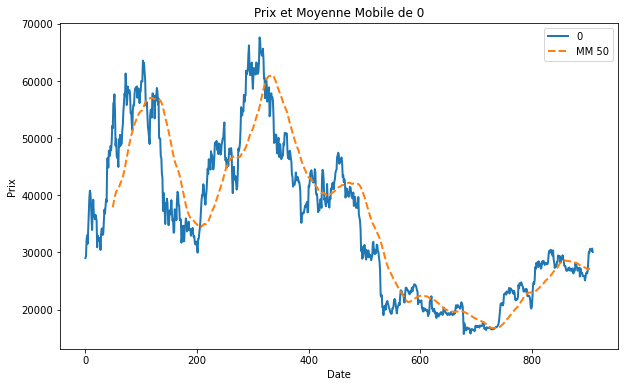

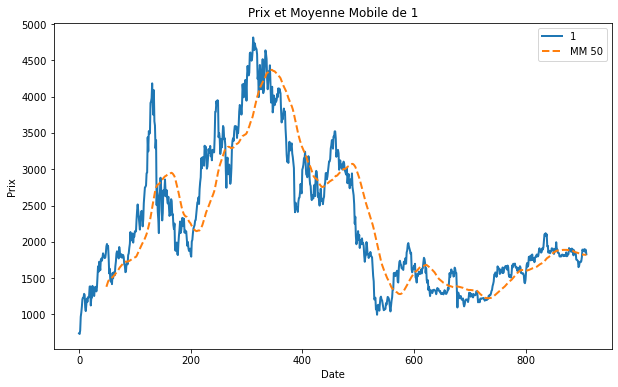

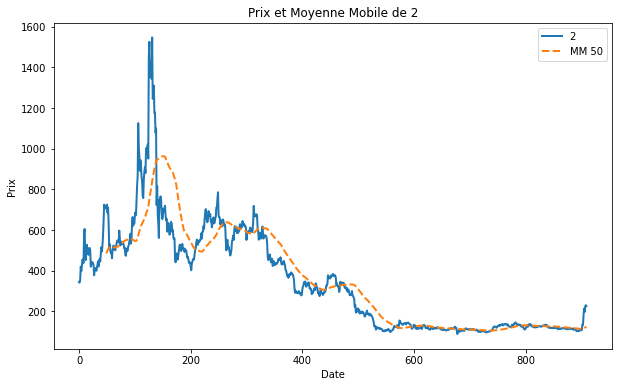

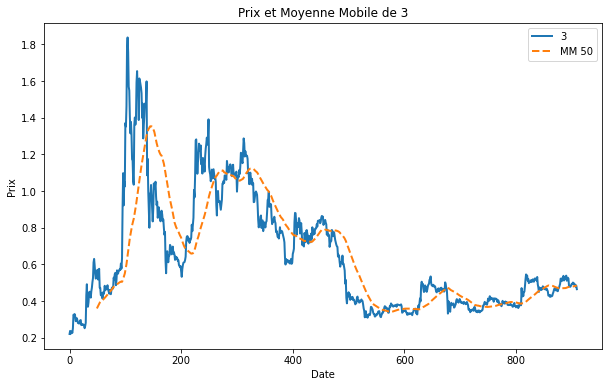

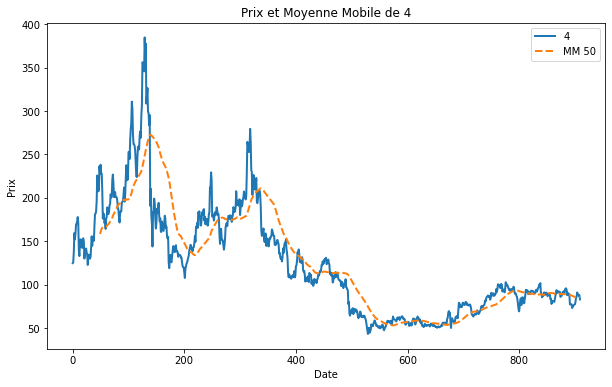

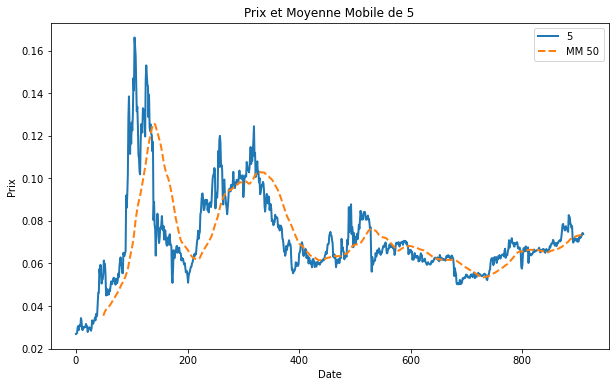

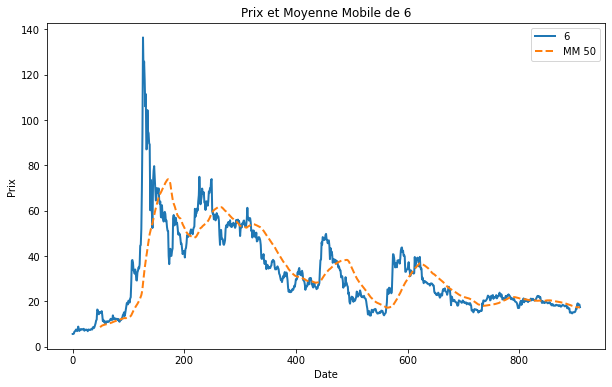

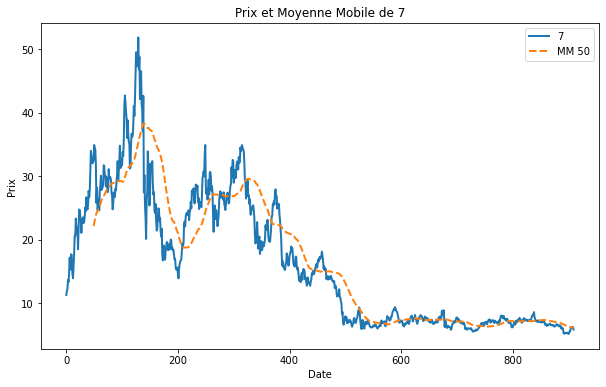

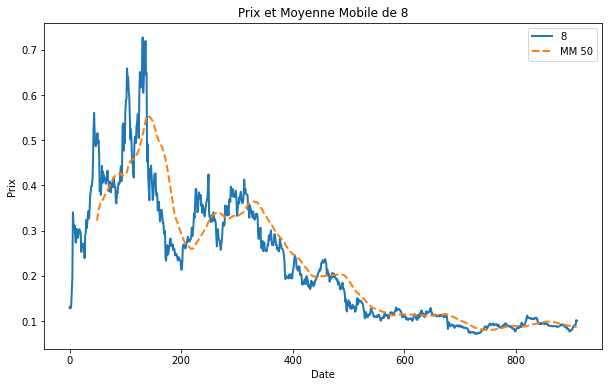

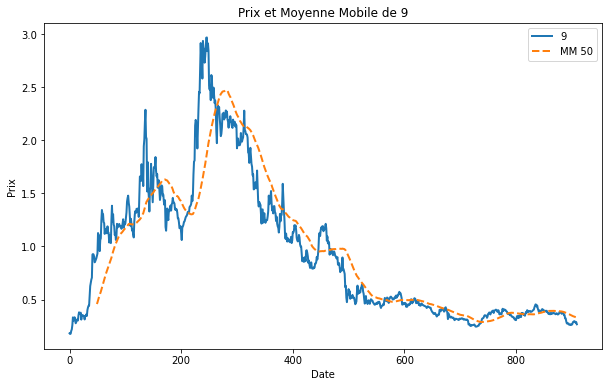

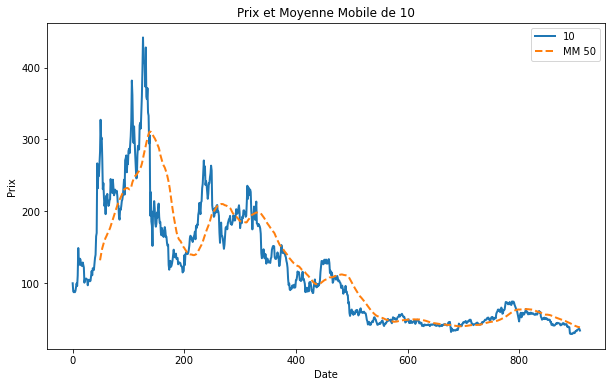

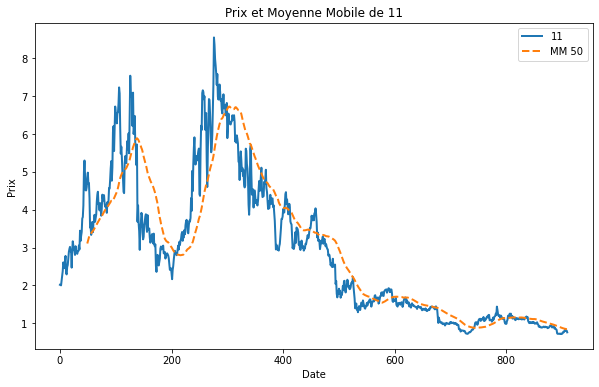

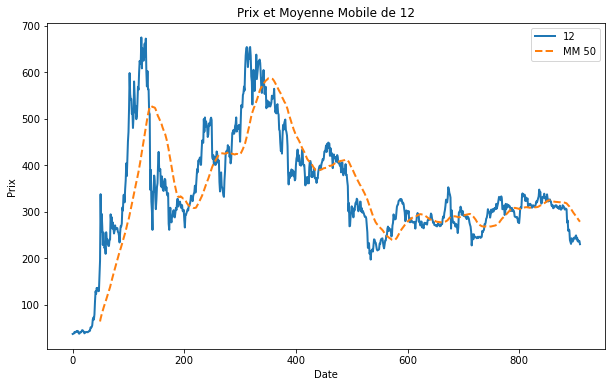

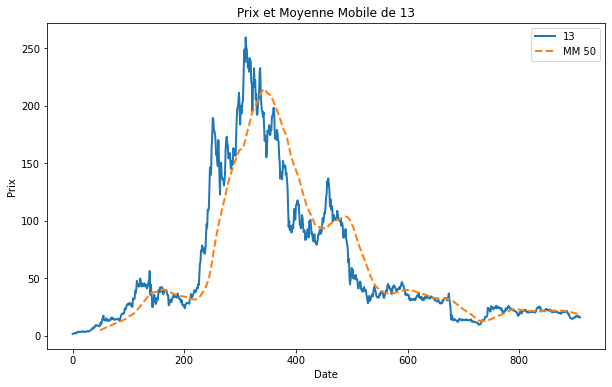

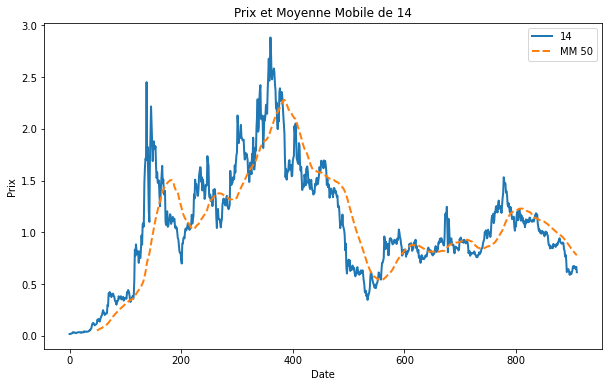

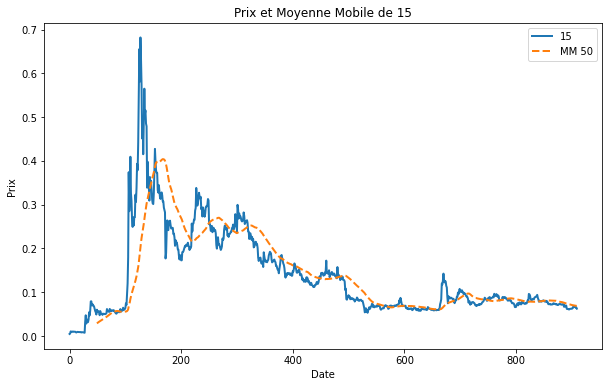

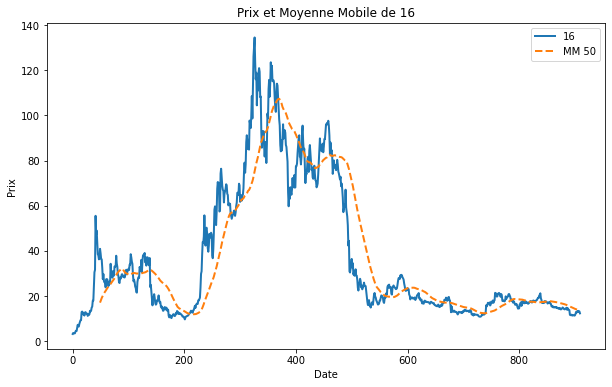

In [81]:
# Paramètres de la moyenne mobile
fenetre_moyenne_mobile = 50
Prix = pd.DataFrame(dailycryptodata)

# Boucle sur toutes les colonnes (cryptomonnaies) du DataFrame
for actif in Prix.columns:
    prix_actif = Prix[actif]
    
    # Calculer la moyenne mobile
    moyenne_mobile = prix_actif.rolling(window=fenetre_moyenne_mobile).mean()

    # Créer une figure pour chaque cryptomonnaie
    plt.figure(figsize=(10, 6))
    
    # Tracer le prix et la moyenne mobile
    plt.plot(prix_actif, label=actif, linewidth=2)
    plt.plot(moyenne_mobile, label=f'MM {fenetre_moyenne_mobile}', linestyle='--', linewidth=2)

    # Ajouter des titres et des légendes
    plt.title(f'Prix et Moyenne Mobile de {actif}')
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.legend()
    
    # Afficher le graphique
    plt.show()

In [82]:
# Paramètres de la moyenne mobile (à ajuster selon vos besoins)
fenetre_moyenne_mobile = 50

MArdt = pd.DataFrame(prix_actif.rolling(window=fenetre_moyenne_mobile).mean())

for nom in nomsColonnes:
    rdt_actif = dfrdt[nom]
    moyenne_mobilerdt = rdt_actif.rolling(window=fenetre_moyenne_mobile).mean()
    MArdt[nom] = pd.DataFrame(moyenne_mobilerdt)
#Supression des bonnes valeurs
MArdt.dropna()

,16,bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2
49,17.080732,0.013159,0.019620,0.014930,0.019010,0.012920,0.016537,0.019957,0.022637,0.027775,0.032683,0.023787,0.018075,0.044034,0.040425,0.043784,0.049348,0.049933
50,17.795327,0.013054,0.019434,0.013916,0.015589,0.011910,0.015423,0.019586,0.021210,0.026295,0.037150,0.024438,0.016945,0.038309,0.033933,0.042041,0.045962,0.045885
51,18.449079,0.011678,0.018297,0.013889,0.018189,0.010079,0.015672,0.019996,0.020619,0.027152,0.036488,0.024874,0.017068,0.040850,0.036378,0.042759,0.033502,0.046732
52,19.103525,0.009996,0.012300,0.008166,0.018741,0.005395,0.012147,0.014979,0.016832,0.024716,0.033654,0.022439,0.014050,0.037542,0.038089,0.040574,0.033381,0.044769
53,19.683394,0.008701,0.008437,0.005142,0.014023,0.002947,0.007709,0.010072,0.013201,0.017284,0.029479,0.019463,0.008853,0.034891,0.036681,0.035152,0.031996,0.041151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,13.988523,0.000678,-0.001226,0.011540,0.000791,0.000187,0.000308,-0.000472,-0.003253,-0.000861,-0.006183,-0.006561,-0.004396,-0.006469,-0.006327,-0.008429,-0.003725,-0.005783
905,13.901220,0.001056,-0.000013,0.010426,0.001243,0.001100,0.000760,-0.000672,-0.002427,-0.000235,-0.005281,-0.004997,-0.003598,-0.006027,-0.005191,-0.007640,-0.002853,-0.004273
906,13.837228,0.001137,-0.000377,0.013072,0.001124,0.000800,0.001189,-0.000229,-0.002693,-0.000096,-0.005963,-0.004790,-0.003867,-0.006219,-0.006019,-0.008115,-0.003468,-0.004533
907,13.770342,0.002055,0.000436,0.014493,0.002396,0.002437,0.001671,0.000423,-0.001224,0.002583,-0.004915,-0.002878,-0.002462,-0.005581,-0.004368,-0.006095,-0.002033,-0.003105


In [83]:
moyenne_mobilerdt = dfrdt.rolling(window=fenetre_moyenne_mobile).mean()
MArdt = pd.DataFrame(moyenne_mobilerdt)
MArdt.dropna()
# Fonction pour appliquer le style
def style_top3(MArdt):
    is_top3 = MArdt.isin(MArdt.nlargest(3))
    is_bottom3 = MArdt.isin(MArdt.nsmallest(3))
    
    styles = ['' for _ in range(len(MArdt))]
    
    for i, (top, bottom) in enumerate(zip(is_top3, is_bottom3)):
        if top:
            styles[i] = 'background-color: lightgreen' #3 meilleurs du jour
        elif bottom:
            styles[i] = 'background-color: lightcoral' #3 pires du jour

    return styles

# Appliquer le style
MArdt = MArdt.style.apply(style_top3, axis=1)

# Afficher le DataFrame stylisé
MArdt

,bitcoin,ethereum,bitcoin-cash,ripple,litecoin,tron,ethereum-classic,chainlink,stellar,cardano,dash,tezos,binancecoin,solana,matic-network,dogecoin,avalanche-2
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [84]:
# Fenêtres pour court, moyen et long terme
fenetres = {'Court Terme': 20, 'Moyen Terme': 50, 'Long Terme': 200}

# Dictionnaires pour stocker les résultats
top_momentum_actifs = {}
bottom_momentum_actifs = {}
portfolios_momentum = {}
portfolios_longshort = {}

for terme, fenetre in fenetres.items():
    # Calcul du momentum
    momentum = dfrdt.rolling(window=fenetre).mean()

    # Top et bottom 5 actifs
    top_actifs = momentum.iloc[-1].nlargest(5).index
    bottom_actifs = momentum.iloc[-1].nsmallest(5).index

    # Stocker les résultats
    top_momentum_actifs[terme] = top_actifs
    bottom_momentum_actifs[terme] = bottom_actifs

    # Portefeuille basé sur le momentum
    portfolios_momentum[terme] = pd.concat([pd.Series(1, index=top_actifs),pd.Series(-1, index=bottom_actifs)])

    # Portefeuille long-short
    portfolio_longshort = pd.concat([pd.Series(1, index=top_actifs), pd.Series(-1, index=bottom_actifs)])
    portfolios_longshort[terme] = portfolio_longshort

# Créer des DataFrames à partir des dictionnaires
df_top_momentum_actifs = pd.DataFrame(top_momentum_actifs)
df_bottom_momentum_actifs = pd.DataFrame(bottom_momentum_actifs)
df_portfolios_momentum = pd.DataFrame(portfolios_momentum)
df_portfolios_longshort = pd.DataFrame(portfolios_longshort)

# Affichage des résultats
print("Top Momentum Actifs par Terme:")
print(df_top_momentum_actifs)

print("\nBottom Momentum Actifs par Terme:")
print(df_bottom_momentum_actifs)

print("\nPortfolios Momentum par Terme:")
print(df_portfolios_momentum)

print("\nPortfolios Long-Short par Terme:")
print(df_portfolios_longshort)

Top Momentum Actifs par Terme:
        Court Terme   Moyen Terme    Long Terme
0      bitcoin-cash  bitcoin-cash  bitcoin-cash
1           stellar       stellar       bitcoin
2           bitcoin       bitcoin      ethereum
3  ethereum-classic        ripple          tron
4          ethereum          tron        ripple

Bottom Momentum Actifs par Terme:
     Court Terme    Moyen Terme     Long Terme
0  matic-network  matic-network       dogecoin
1        cardano        cardano  matic-network
2         solana    binancecoin           dash
3           dash         solana          tezos
4    binancecoin    avalanche-2    binancecoin

Portfolios Momentum par Terme:
                  Court Terme  Moyen Terme  Long Terme
avalanche-2               NaN         -1.0         NaN
binancecoin              -1.0         -1.0        -1.0
bitcoin                   1.0          1.0         1.0
bitcoin-cash              1.0          1.0         1.0
cardano                  -1.0         -1.0         NaN
da

Top Momentum Actifs par Terme
Court Terme: On observe que 'bitcoin-cash', 'stellar', et 'bitcoin' figurent parmi les cryptomonnaies avec le plus fort momentum. Cela indique qu'ils ont eu des performances relativement meilleures dans la période récente (20 jours).
Moyen Terme: 'bitcoin-cash', 'stellar', et 'bitcoin' se maintiennent comme actifs à fort momentum sur une période de 50 jours, montrant une tendance constante dans leur performance.
Long Terme: Sur 200 jours, 'bitcoin-cash' continue de montrer un fort momentum, mais 'ethereum' et 'ripple' émergent aussi comme des actifs performants.
Bottom Momentum Actifs par Terme
Court Terme: 'matic-network', 'cardano', et 'solana' sont parmi les actifs avec le pire momentum. Cela pourrait indiquer une période récente de sous-performance ou de volatilité.
Moyen Terme: 'matic-network' et 'cardano' restent en bas de la liste, indiquant une tendance négative persistante.
Long Terme: 'dogecoin', 'matic-network', et 'dash' apparaissent comme des actifs à faible momentum sur une période plus longue.
Portefeuilles Momentum
Court Terme: Les actifs sélectionnés sont principalement les mêmes que ceux identifiés comme ayant le meilleur momentum à court terme.
Moyen et Long Terme: Les portefeuilles se diversifient un peu plus, avec des actifs comme 'ripple' et 'tron' apparaissant dans le portefeuille à moyen terme et 'ethereum' conservant sa place dans le portefeuille à long terme.
Portefeuilles Long-Short
Les portefeuilles long-short montrent une combinaison d'investissements dans les actifs à fort momentum (long) et de paris contre ceux à faible momentum (short).
Sur tous les termes, 'bitcoin' et 'bitcoin-cash' sont constamment choisis pour des positions longues, tandis que 'binancecoin' et 'matic-network' apparaissent fréquemment dans des positions courtes.
Intéressant de noter, certains actifs comme 'ethereum' et 'tron' apparaissent dans des positions longues pour certains termes et sont absents dans d'autres, suggérant une variation dans leur performance relative en fonction de la période considérée.

### Analyse des Résultats

#### Top Momentum Actifs par Terme
- **Court Terme**: 'bitcoin-cash', 'stellar', et 'bitcoin' montrent un momentum élevé, indiquant des performances supérieures récentes.
- **Moyen Terme**: Les mêmes actifs ('bitcoin-cash', 'stellar', 'bitcoin') continuent d'afficher un fort momentum.
- **Long Terme**: 'bitcoin-cash' reste en tête, avec 'ethereum' et 'ripple' montrant également une bonne performance.

#### Bottom Momentum Actifs par Terme
- **Court Terme**: 'matic-network', 'cardano', et 'solana' affichent le pire momentum.
- **Moyen Terme**: 'matic-network' et 'cardano' maintiennent une tendance négative.
- **Long Terme**: 'dogecoin', 'matic-network', et 'dash' émergent comme les actifs les moins performants.

#### Portefeuilles Momentum
- **Court Terme**: Principalement composé d'actifs ayant le meilleur momentum à court terme.
- **Moyen et Long Terme**: Plus de diversification avec 'ripple' et 'tron' apparaissant à moyen terme, et 'ethereum' restant à long terme.

#### Portefeuilles Long-Short
- Positions longues constantes sur 'bitcoin' et 'bitcoin-cash', tandis que 'binancecoin' et 'matic-network' apparaissent souvent en short.
- Variabilité dans la performance relative de certains actifs comme 'ethereum' et 'tron' selon la période.

### Implications pour la Stratégie d'Investissement
- **Diversification Temporelle**: L'importance d'examiner des horizons temporels variés dans la construction de portefeuilles.
- **Surveillance des Tendances**: 'bitcoin-cash' et 'bitcoin' montrent une tendance haussière constante, alors que 'matic-network' indique une tendance baissière.
- **Stratégie de Trading**: Une approche équilibrée pourrait être d'investir long sur les actifs à momentum positif et court sur ceux à momentum négatif pour gérer les risques.
